Audio Classifier
=========================

1: Importing the Dataset
---------------------

We will use the UrbanSound8K dataset to train our network. It is
available for free `here <https://urbansounddataset.weebly.com/>`_ and contains
10 audio classes with over 8000 audio samples! Once you have downloaded
the compressed dataset, extract it to your current working directory.
First, we will look at the csv file that provides information about the
individual sound files. ``pandas`` allows us to open the csv file and
use ``.iloc()`` to access the data within it.




The 10 audio classes in the UrbanSound8K dataset are air_conditioner,
car_horn, children_playing, dog_bark, drilling, enginge_idling,
gun_shot, jackhammer, siren, and street_music. Let’s play a couple files
and see what they sound like. The first file is street music and the
second is an air conditioner.




2: Formatting the Data
-------------------

Now that we know the format of the csv file entries, we can construct
our dataset. We will create a rapper class for our dataset using
``torch.utils.data.Dataset`` that will handle loading the files and
performing some formatting steps. The UrbanSound8K dataset is separated
into 10 folders. We will use the data from 9 of these folders to train
our network and then use the 10th folder to test the network. The rapper
class will store the file names, labels, and folder numbers of the audio
files in the inputted folder list when initialized. The actual loading
and formatting steps will happen in the access function ``__getitem__``.

In ``__getitem__``, we use ``torchaudio.load()`` to convert the wav
files to tensors. ``torchaudio.load()`` returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(44.1kHz for UrbanSound8K). The dataset uses two channels for audio so
we will use ``torchaudio.transforms.DownmixMono()`` (not available in the latest version of `torchaudio`) to convert the audio
data to one channel. Next, we need to format the audio data. The network
we will make takes an input size of 32,000, while most of the audio
files have well over 100,000 samples. The UrbanSound8K audio is sampled
at 44.1kHz, so 32,000 samples only covers around 700 milliseconds. By
downsampling the audio to aproximately 8kHz, we can represent 4 seconds
with the 32,000 samples. This downsampling is achieved by taking every
fifth sample of the original audio tensor. Not every audio tensor is
long enough to handle the downsampling so these tensors will need to be
padded with zeros. The minimum length that won’t require padding is
160,000 samples.




3: Define the Network
------------------

For this task we want to closely reproduce the achitectures described in https://arxiv.org/pdf/1610.00087.pdf. You task is to read extensively the paper and reproduce the achitectures <font color='green'> M3, M5, M11 and M18. The M34-res is a bonus.</font>
While attempting to reproduce the architectures endeavour to read through the common [pitfalls](https://urbansounddataset.weebly.com/urbansound8k.html#10foldCV) to get it right.

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training.




4: Training and Testing the Network
--------------------------------

You can define a training function that will feed our training data into the model and perform the backward pass and optimization steps. You can also make one for testing the networks accuracy and set the model to ``eval()`` mode and then run inference on the test dataset. Calling ``eval()`` sets the training variable in all modules in the network to false. Certain layers like batch normalization and dropout layers behave differently during training so this step is crucial for getting correct results.




Finally, we can train and test the network. Train the network for as many epochs as time allows you. The network will be tested after each epoch to see how the accuracy varies during the training.

Conclusion
----------

If trained on 9 folders, the network should be about 40% accurate by the end of the training process for the least possible epochs. Training on less folders will result in a lower overall accuracy. Greater accuracies can be achieved using deeper CNNs at the expense of a larger memory footprint.

For more advanced audio applications, such as speech recognition,
recurrent neural networks (RNNs) are commonly used. There are also other
data preprocessing methods, such as finding the mel frequency cepstral
coefficients (MFCC), that can reduce the size of the dataset.




In [ ]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# install library
# !pip install --upgrade wandb
# !wandb login 72d925ac92507f2d015daabb78fb3a8b7939fdf4
!pip install torchaudio

     |████████████████████████████████| 2.7MB 42.6MB/s 
     |████████████████████████████████| 773.1MB 23kB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


In [ ]:
# Download dataset from the official website 
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
!tar -xf UrbanSound8K.tar.gz

--2019-12-11 21:09:48--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.95.95
Connecting to zenodo.org (zenodo.org)|188.184.95.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘UrbanSound8K.tar.gz’

UrbanSound8K.tar.gz 100%[===================>]   5.61G  24.7MB/s    in 4m 33s  

2019-12-11 21:14:22 (21.0 MB/s) - ‘UrbanSound8K.tar.gz’ saved [6023741708/6023741708]



In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchaudio

In [ ]:
class AudioDataset(Dataset):
  """
  A rapper class for the UrbanSound8K dataset.
  """

  def __init__(self, file_path, audio_paths, folds):
    """
    Args:
        file_path(string): path to the audio csv file
        root_dir(string): directory with all the audio folds
        folds: integer corresponding to audio fold number or list of fold number if more than one fold is needed
    """
    self.audio_file = pd.read_csv(file_path)
    self.folds = folds
    self.audio_paths = glob.glob(audio_paths + '/*' + str(self.folds) + '/*')
  
  def __len__(self):
    return len(self.audio_paths)

  def __getitem__(self, idx):
    # if isinstance(subscript, slice):
    #     # do your handling for a slice object:
    #     print(subscript.start, subscript.stop, subscript.step)
    # else:
    #     # Do your handling for a plain index
    #     print(subscript)
    
    audio_path = self.audio_paths[idx]
    audio, rate = torchaudio.load(audio_path, normalization=True)
    audio = audio.mean(0, keepdim=True)
    c, n = audio.shape
    zero_need = 160000 - n
    audio_new = F.pad(audio, (zero_need //2, zero_need //2), 'constant', 0)
    audio_new = audio_new[:,::5]
    
    #Getting the corresponding label
    audio_name = audio_path.split(sep='/')[-1]
    labels = self.audio_file.loc[self.audio_file.slice_file_name == audio_name].iloc[0,-2]
    
    return audio_new, labels

# Beginning of work

## Models

In [ ]:
#Counting Parameters of Models
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

### M3

In [ ]:
#M3 model
def getM3():
    return nn.Sequential(
        #[80/4, 256]
        nn.Conv1d(1,256,kernel_size=80, stride=4, padding=38),
        nn.BatchNorm1d(256),
        nn.ReLU(),

        nn.MaxPool1d(4),

        #[3, 256]
        nn.Conv1d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),

        nn.MaxPool1d(4),

        # Global average pooling
        nn.AdaptiveAvgPool1d(1), # or nn.AvgPool1d(500),

        # Output
        nn.Flatten(),
        nn.Linear(256,10) # or nn.Softmax(1),
    )

###code for test
# audio = torch.zeros(1,32000)
# M3(audio.unsqueeze(0)).shape

#print(getM3())
print('Model M3 have {:,d} parameters'.format(count_parameters(getM3())))

Sequential(
  (0): Conv1d(1, 256, kernel_size=(80,), stride=(4,), padding=(38,))
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (8): AdaptiveAvgPool1d(output_size=1)
  (9): Flatten()
  (10): Linear(in_features=256, out_features=10, bias=True)
)
Model M3 have 221,194 parameters


### Helper to build convolution

In [ ]:
#Helper to build convolution module
import math
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=None):
        super(ConvModule, self).__init__()
        
        if padding==None: #padding smae
            padding = math.ceil((kernel_size - stride)/2) #round by exceed
        self.conv  = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.batch = nn.BatchNorm1d(out_channels)
        self.relu  = nn.ReLU()
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x

def Repeat(repeat, module_builder, **kwargs):
    modules = []
    for i in range(repeat):
        if i > 0: kwargs['in_channels'] = kwargs['out_channels']
        modules.append( module_builder(**kwargs) )
    return nn.Sequential( *modules )

###code for test
# audio = torch.zeros(48,32000)
# net  = ConvModule(48,48,3,padding=1)
# net(audio.unsqueeze(0)).shape

### M5

In [ ]:
#M5 model
def getM5():
    return nn.Sequential(
        #[80/4, 128]
        ConvModule(1,128,kernel_size=80, stride=4),#, padding=38),
        nn.MaxPool1d(4),
        
        #[3, 128]
        ConvModule(128, 128, kernel_size=3),#, padding=1),
        nn.MaxPool1d(4),
        
        #[3, 256] 
        ConvModule(128, 256, kernel_size=3),#, padding=1),
        nn.MaxPool1d(4),
        
        #[3, 512]
        ConvModule(256, 512, kernel_size=3, padding=3),
        nn.MaxPool1d(4),
        
        # Global average pooling
        nn.AdaptiveAvgPool1d(1),

        # Ouput
        nn.Flatten(),
        nn.Linear(512,10)
    )

###code for test
# audio = torch.zeros(1,32000)
# print(getM5()(audio.unsqueeze(0)).shape)

# print(getM5())
print('Model M5 have {:,d} parameters'.format(count_parameters(getM5())))

Sequential(
  (0): ConvModule(
    (conv): Conv1d(1, 128, kernel_size=(80,), stride=(4,), padding=(38,))
    (batch): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): ConvModule(
    (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (batch): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (4): ConvModule(
    (conv): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (batch): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (6): ConvModule(
    (conv): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(3,))
    (batch): BatchN

### M11

In [ ]:
#M11 model
def getM11():
    return nn.Sequential(
        #[80/4, 64]
        ConvModule(1,64,kernel_size=80, stride=4, padding=38),

        nn.MaxPool1d(4),

        #[3, 64] × 2 
        ConvModule(64, 64, kernel_size=3, padding=1),
        ConvModule(64, 64, kernel_size=3, padding=1),

        nn.MaxPool1d(4),

        #[3, 128] × 2
        ConvModule(64,  128, kernel_size=3, padding=1),
        ConvModule(128, 128, kernel_size=3, padding=1),

        nn.MaxPool1d(4),

        #[3, 256] × 3
        # Repeat(3, ConvModule, in_channels=128, out_channels=256, kernel_size=3, padding=2),
        ConvModule(128, 256, kernel_size=3, padding=2),
        ConvModule(256, 256, kernel_size=3, padding=2),
        ConvModule(256, 256, kernel_size=3, padding=2),

        nn.MaxPool1d(4),

        #[3, 512] × 2 
        ConvModule(256, 512, kernel_size=3, padding=2),
        ConvModule(512, 512, kernel_size=3, padding=2),

        # Global average pooling
        nn.AdaptiveAvgPool1d(1),

        # Output
        nn.Flatten(),
        nn.Linear(512,10)
    )

###code for test
# audio = torch.zeros(1,32000)
# M11(audio.unsqueeze(0)).shape

# print(getM11())
print('Model M11 have {:,d} parameters'.format(count_parameters(getM11())))

### M18

In [ ]:
#M18 Model
def getM18():
    return nn.Sequential(
        #[80/4, 64]
        ConvModule(1,64,kernel_size=80, stride=4, padding=38),

        nn.MaxPool1d(4),
        
        #[3, 64] × 4
        ConvModule(64, 64, kernel_size=3, padding=1),
        ConvModule(64, 64, kernel_size=3, padding=1),
        ConvModule(64, 64, kernel_size=3, padding=1),
        ConvModule(64, 64, kernel_size=3, padding=1),
        
        nn.MaxPool1d(4),
        
        #[3, 128] × 4
        ConvModule(64,  128, kernel_size=3, padding=1),
        ConvModule(128, 128, kernel_size=3, padding=1),
        ConvModule(128, 128, kernel_size=3, padding=1),
        ConvModule(128, 128, kernel_size=3, padding=1),
        
        nn.MaxPool1d(4),
        
        #[3, 256] × 4
        ConvModule(128, 256, kernel_size=3, padding=2),
        ConvModule(256, 256, kernel_size=3, padding=2),
        ConvModule(256, 256, kernel_size=3, padding=2),
        ConvModule(256, 256, kernel_size=3, padding=1),
        
        nn.MaxPool1d(4),
        
        # [3, 512] × 4
        ConvModule(256, 512, kernel_size=3, padding=2),
        ConvModule(512, 512, kernel_size=3, padding=2),
        ConvModule(512, 512, kernel_size=3, padding=2),
        ConvModule(512, 512, kernel_size=3, padding=2),
        
        # Global average pooling
        nn.AdaptiveAvgPool1d(1),
        
        # Output
        nn.Flatten(),
        nn.Linear(512,10),
        nn.Softmax(1)
    )

###code for test
# audio = torch.zeros(1,32000)
# M18(audio.unsqueeze(0)).shape

# print(getM18())
print('Model M18 have {:,d} parameters'.format(count_parameters(getM18())))

Model M18 have 3,683,786 parameters


### Helper to build resnet module

In [ ]:
#Helper to build resnet module
class ResNetModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ResNetModule, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.batch1 = nn.BatchNorm1d(out_channels)
        self.relu1  = nn.ReLU()
        
        self.conv2  = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
        self.batch2 = nn.BatchNorm1d(out_channels)
        
        self.batch3 = nn.BatchNorm1d(out_channels)
        self.relu2  = nn.ReLU()
        
    def forward(self,x):
        x1 = self.conv1(x)
        x1 = self.batch1(x1)
        x1 = self.relu1(x1)
        
        x1 = self.conv2(x1)
        x1 = self.batch2(x1)
        
        # print(x1.shape, x.shape)
        if x1.shape[1] != x.shape[1]:
            # x = x.repeat(1,2,1) # repeat channel by block
            x = torch.repeat_interleave(x, 2, dim=1) # repeat element by element
            #TODO: check if its correct
            
        x = x1 + x
        x = self.batch3(x)
        x = self.relu2(x)
        return x

###code for test
# audio = torch.zeros(10, 48,1000)
# net  = ResNetModule(48,96,3,padding=1)
# net(audio).shape

### M34res

In [ ]:
#M34-res model
def getM34res():
    return nn.Sequential(
        #[80/4, 48]
        ConvModule(1,48,kernel_size=80, stride=4, padding=38),
    
        nn.MaxPool1d(4),
        
        #[3, 48]
        #[3, 48] × 3
        ResNetModule(48,48,3),
        ResNetModule(48,48,3),
        ResNetModule(48,48,3),
        
        nn.MaxPool1d(4),
        
        #[3, 96]
        #[3, 96] × 4
        ResNetModule(48,96,3),
        ResNetModule(96,96,3),
        ResNetModule(96,96,3),
        ResNetModule(96,96,3),
        
        nn.MaxPool1d(4),
        
        #[3, 192]
        #[3, 192] × 6
        ResNetModule(96, 192,3),
        ResNetModule(192,192,3),
        ResNetModule(192,192,3),
        ResNetModule(192,192,3),
        ResNetModule(192,192,3),
        ResNetModule(192,192,3),
        
        nn.MaxPool1d(4),
        
        #[3, 384]
        #[3, 384] × 3
        ResNetModule(192,384,3),
        ResNetModule(384,384,3),
        ResNetModule(384,384,3),
        
        # Global average pooling
        nn.AdaptiveAvgPool1d(1),
        
        # Output
        nn.Flatten(),
        nn.Linear(384,10)
    )

###code for test
# audio = torch.zeros(1,32000)
# print(getM34res()(audio.unsqueeze(0)).shape)

print(getM34res())
print('Model M34-res have {:,d} parameters'.format(count_parameters(getM34res())))

Model M34-res have 3,984,154 parameters


## Training Loop & Test

In [ ]:
# import wandb
# wandb.init(project="audio-classification")
import time
import math

def weight_init(m):
    if isinstance(m, torch.nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight)
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

def calc_accuracy(ouputs,targets):
    max_index = ouputs.max(dim = 1)[1]
    return (max_index == targets).sum().item()

def train_eval(model, trainloader, testloader, total_epochs=10,
               learning_rate=0.01, lr_decay_to=0.001,
               device='cuda:0'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # for the scheduler we just need to know the good value muliplier
    # detailled explanation at the bottom
    lr_multiplier = math.exp(math.log(lr_decay_to/learning_rate)/(total_epochs-1))
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_multiplier)
    
    model.to(device)
    # wandb.watch(net, log='all')

    train_acc, test_acc   = [], []
    train_loss, test_loss = [], []
    # loop over the dataset multiple times
    for epoch in range(total_epochs):
        print('Epoch: {}'.format(epoch))
        start_time = time.time()    

        model.train()
        # train for 1 epoch on the train set
        total_loss, correct = 0, 0
        for i, (batch, targets) in enumerate(trainloader):    
            # print('batch :',i)      
            # batch and targets to cuda 
            batch, targets  = batch.to(device), targets.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward 
            outputs = model(batch)
            loss = criterion(outputs, targets)

            # backward
            loss.backward()
            
            # gradient step 
            optimizer.step()

            # save loss and accuracy
            total_loss += loss.data.sum().item()
            correct += calc_accuracy(outputs, targets)
            
            #free gpu memory    
            del batch, targets, loss
        
        scheduler.step()
        ###test code
        # check learning rate value
        # for param_group in optimizer.param_groups:
        #     print("param_group['lr']", param_group['lr'])

        mean_accuracy = correct / len(trainloader.dataset) 
        mean_loss     = total_loss / len(trainloader.dataset)
        
        train_acc.append(mean_accuracy)
        train_loss.append(mean_loss)

        elapsed = time.time() - start_time
        print('Train accuracy: {:.2f}%,   {:5.1f} seconds/epoch'.format(mean_accuracy*100, elapsed))

        # evaluate on the testset
        model.eval()
        with torch.no_grad():
            total_loss, correct = 0, 0
            for i, (batch, targets) in enumerate(testloader):

                # batch and targets to cuda 
                batch = batch.to(device)
                targets = targets.to(device)
            
                # forward
                outputs = model(batch)
                loss = criterion(outputs, targets)
                total_loss += loss.data.sum().item()

                # compute accuracy 
                correct += calc_accuracy(outputs, targets)
                
                #free gpu memory
                del batch, targets, loss
        
            mean_accuracy = correct / len(testloader.dataset) 
            mean_loss     = total_loss / len(testloader.dataset)
            
            test_acc.append(mean_accuracy)
            test_loss.append(mean_loss)
            print('Test accuracy: {:.2f}%'.format(mean_accuracy*100))

    torch.cuda.empty_cache()

    return {
        'train_acc'  : train_acc,
        'test_acc'   : test_acc,
        'train_loss' : train_loss,
        'test_loss'  : test_loss
    }

#### test code
# for learning rate decay 
# the scheduler multiply the learning by a value
# we just need to nkow the value of the multiplier
# to reach the value of the learning rate that we need
# at the end of training last epochs

# formular : a* 0.9**n = b >>  learning_rate * lr_multiplier**total_epochs = lr_decay_to
# learning_rate = 0.01
# lr_decay_to = 0.001
# epochs = 10

# calc multiplier to get 0.001 at the end of the 10 epochs
# lr_multiplier = math.exp(math.log(lr_decay_to/learning_rate)/epochs)
# lr_multiplier , learning_rate * lr_multiplier**epochs

## Helper to save the logs in file

In [ ]:
from datetime import datetime
import pickle
import glob
import os

def save_store(store, log_path, tag=''):
    date_str = datetime.now().strftime("%d-%Hh:%Mm")
    filename = 'log.'+tag+'_'+date_str+'.dict'
    with open(log_path+'/'+filename, 'wb') as f:
        pickle.dump(store, f)
    print('Successful save :',filename)

def load_store(log_path=None, filename=''):
    path_pattern = log_path + '/*.dict'

    if log_path:
        list_of_files = glob.glob(path_pattern) 
        latest_file = max(list_of_files, key=os.path.getctime)
        filename = latest_file

    print('Loading : ',filename)
    with open(filename, 'rb') as f:
        store = pickle.load(f)

    return store

##### code for test
# log_path = '/content/drive/My Drive/audio_classification/logs'
# tag = 'M8-fold' #last log
# store_ = {'M3': {'fold1': {'train_acc': [409.8510882365608, 419.816723870521], 'test_acc': [35.62428392495487, 36.42611679479156], 'train_loss': [0.16262847137341932, 0.161868661949315], 'test_loss': [0.016730055093492156, 0.016776290273065556]}}}
# save_store(store_, log_path, tag)

### Defining path for datatset

In [ ]:
#dataset path
file_path = '/content/UrbanSound8K/metadata/UrbanSound8K.csv'
audio_paths = '/content/UrbanSound8K/audio'

#for dataset in google drive
# file_path = '/content/drive/My Drive/audio_classification/UrbanSound8K/metadata/UrbanSound8K.csv'
# audio_paths = '/content/drive/My Drive/audio_classification/UrbanSound8K/audio'

In [ ]:
#log of the training (in your google drive if you're using colab)
log_path = '/content/drive/My Drive/audio_classification/logs'

## Training all models across all folds

In [ ]:
models_builder = [getM3, getM5, getM11, getM18, getM34res]
models_name = ['M3', 'M5', 'M11', 'M18', 'M34res']
folds = ['fold1','fold2','fold3','fold4','fold5','fold6','fold7','fold8','fold9','fold10']

#load store
try:
    #load the last store
    store = load_store(log_path)  
except:
    #if not found use an empty store
    store = dict()

#loop on all the models
for model_builder, model_name in zip(models_builder,models_name):
    # loop on all the folds
    for i in range(len(folds)):
        
        #check if we already have this task in the store
        if model_name in store:
            if folds[i] in store[model_name]:
                print('{} {} already exist. Skip training.'.format(model_name,folds[i]))
                continue
        else:
            store[model_name] = dict()
        start_time = time.time()

        print('\n{} : Training on {} {} '.format(datetime.now().strftime("%H:%M:%S"), model_name, folds[i]))

        #dataset
        traindata = AudioDataset(file_path, audio_paths, folds[0:i]+folds[i+1:10])
        testdata  = AudioDataset(file_path, audio_paths, folds[i])

        #create dataloader
        trainloader = torch.utils.data.DataLoader(traindata, batch_size=128, shuffle=True, num_workers=3)
        testloader  = torch.utils.data.DataLoader(testdata,  batch_size=128, num_workers=2)

        model = model_builder()
        model.apply(weight_init) # for glorot xavier_uniform initialisation
        
        log = train_eval(model, trainloader, testloader, total_epochs=10)
        print('Duration   {:5.1f} mins/epoch'.format((time.time() - start_time)/60))

        #save log for accuracy and loss
        store[model_name][folds[i]] = log

        #save in file to continue after shutdown
        tag = model_name+'-'+folds[i]
        save_store(store, log_path, tag)
        
        #free gpu memory
        del model


In [ ]:
#delete saved all stored logs
#!rm '/content/drive/My Drive/audio_classification/logs/log*.dict'

## Final results

A dictionary of all the train and test accuracies and losses for all five networks. There is no need to retrain for the values as store_ contains the already trained and tested values that we need.

In [ ]:
#backup of all the logs of training with 10epochs for 10folds with all the networks
store_ = {'M3': {'fold1': {'train_acc': [0.2938616582684379, 0.40563444800732934, 0.43025652771415485, 0.46392579019697666, 0.48774622079706825, 0.5085890975721484, 0.5229042601923958, 0.5414567109482363, 0.5466101694915254, 0.5635593220338984], 'test_acc': [0.35624284077892326, 0.4261168384879725, 0.45017182130584193, 0.3951890034364261, 0.4627720504009164, 0.46048109965635736, 0.4936998854524628, 0.5074455899198167, 0.5315005727376861, 0.4936998854524628], 'train_loss': [0.016407440028712666, 0.01359821799366069, 0.012722030261542564, 0.01213157519636709, 0.011564027099941391, 0.011242812399573683, 0.010997022134800106, 0.010697583976383882, 0.01042297423786927, 0.010147075354370347], 'test_loss': [0.014779194660339705, 0.013571302915356824, 0.012752081930022878, 0.013320151200136096, 0.011664777686915448, 0.012054085048749821, 0.011378153356353305, 0.011620455044924462, 0.010857580999874713, 0.01065434786871946]}, 'fold2': {'train_acc': [0.2853136155022947, 0.40464048954614995, 0.4572921978582356, 0.48597654258031614, 0.49324324324324326, 0.5128760836308006, 0.530979092299847, 0.5455124936257012, 0.5609382967873534, 0.5652728199898012], 'test_acc': [0.32545045045045046, 0.3119369369369369, 0.34572072072072074, 0.36599099099099097, 0.29504504504504503, 0.37725225225225223, 0.3738738738738739, 0.38963963963963966, 0.36486486486486486, 0.3997747747747748], 'train_loss': [0.016407184625754, 0.01378106830802151, 0.012548678037404164, 0.011955004574874419, 0.011681555333884014, 0.01127362283196515, 0.01079738947094125, 0.010532985272789293, 0.01022708577078742, 0.010104667131296534], 'test_loss': [0.014928274729230383, 0.014951117403872378, 0.013534515961870417, 0.014090809736165914, 0.014335876246830364, 0.01389506929092579, 0.01375934911203814, 0.013966232135489181, 0.01429194856334377, 0.014484412095568201]}, 'fold3': {'train_acc': [0.2879467144869988, 0.4130908159344178, 0.45472012296656844, 0.4709875752529781, 0.49173818368131167, 0.5169719482515691, 0.5323427693095939, 0.5521967465095428, 0.5583450749327526, 0.562443960548226], 'test_acc': [0.33945945945945943, 0.3675675675675676, 0.3902702702702703, 0.38054054054054054, 0.4172972972972973, 0.412972972972973, 0.4097297297297297, 0.46054054054054056, 0.3945945945945946, 0.4735135135135135], 'train_loss': [0.01614131589422645, 0.013394864585498269, 0.012318081856995488, 0.011745621716150083, 0.01132872824756226, 0.010893762531576135, 0.010576245389889247, 0.010153093517582472, 0.009968691695525916, 0.009749844420257017], 'test_loss': [0.016864911414481498, 0.016779658601090715, 0.015767709242331014, 0.016362227878055056, 0.01650658014658335, 0.016953341380969898, 0.016523038761035815, 0.01670261859893799, 0.018258780917605837, 0.016268832748000686]}, 'fold4': {'train_acc': [0.30366830276414364, 0.405321622319814, 0.44226298114182383, 0.4631878067682769, 0.5006458279514338, 0.5094290880909326, 0.524541462154482, 0.544562128648928, 0.5570911909067424, 0.5658744510462412], 'test_acc': [0.30808080808080807, 0.3595959595959596, 0.3888888888888889, 0.3696969696969697, 0.40606060606060607, 0.38282828282828285, 0.3888888888888889, 0.45656565656565656, 0.4222222222222222, 0.4505050505050505], 'train_loss': [0.016005806653760134, 0.013340609691396174, 0.012470274678621758, 0.011830288721467444, 0.01130671035840018, 0.011017505711777455, 0.010641522568900035, 0.010366068117934522, 0.009971483198440342, 0.009779495713754515], 'test_loss': [0.016346503508211388, 0.015137516007278905, 0.014917112239683518, 0.015123841256806344, 0.014334166772437817, 0.014596057540238506, 0.014653279925837662, 0.013885373298567955, 0.013888925253742874, 0.013369022354935155]}, 'fold5': {'train_acc': [0.2882247306310929, 0.39943560800410466, 0.43304258594150846, 0.46921498204207285, 0.4880708055413032, 0.4965366854797332, 0.5224474089276552, 0.5356593124679323, 0.5437403796818882, 0.5601590559261159], 'test_acc': [0.29914529914529914, 0.3418803418803419, 0.33974358974358976, 0.3344017094017094, 0.3995726495726496, 0.3525641025641026, 0.37927350427350426, 0.39316239316239315, 0.43482905982905984, 0.41452991452991456], 'train_loss': [0.016242004009685253, 0.013479237329537836, 0.012570346147968807, 0.011860505029322123, 0.011500288930656116, 0.011177089472438445, 0.010731601910813763, 0.010467266076157923, 0.010216643453684142, 0.009993626130673137], 'test_loss': [0.01769136452776754, 0.01739219085783021, 0.01557590296635261, 0.014949757701311355, 0.014608551803817097, 0.014773320693236131, 0.015720671568161402, 0.014643764393961327, 0.013624136264507588, 0.014169435725252852]}, 'fold6': {'train_acc': [0.308635731445189, 0.4040965988114806, 0.45492476925022124, 0.47983310152990266, 0.5116955367303072, 0.5291440131495765, 0.5444430395751675, 0.5516500189657353, 0.5640409659881148, 0.5712479453786825], 'test_acc': [0.3001215066828676, 0.3754556500607533, 0.32563791008505466, 0.3487241798298906, 0.37667071688942894, 0.43863912515188336, 0.3462940461725395, 0.36087484811664644, 0.41190765492102066, 0.4617253948967193], 'train_loss': [0.015928074885204476, 0.01332904610023108, 0.012390578210632695, 0.01172040997692209, 0.011202002072065996, 0.010831449528924583, 0.010429366332177252, 0.010194628937142826, 0.010051847544221665, 0.009734872289125349], 'test_loss': [0.017233807724851884, 0.018527201285194222, 0.016702483954725116, 0.01637933494688384, 0.016859556316315475, 0.015132419828366248, 0.016819474039506507, 0.016208382597236122, 0.015913006601762366, 0.01592942286522681]}, 'fold7': {'train_acc': [0.29414745376235113, 0.40296427666582213, 0.44134785913351915, 0.47099062579174056, 0.4898657208006081, 0.5039270331897644, 0.5306561945781606, 0.5435774005573853, 0.5557385355966556, 0.5649860653661009], 'test_acc': [0.3902147971360382, 0.43675417661097854, 0.4224343675417661, 0.47255369928400953, 0.4307875894988067, 0.44630071599045346, 0.5262529832935561, 0.4964200477326969, 0.4892601431980907, 0.4809069212410501], 'train_loss': [0.015948498448390493, 0.013632489618905924, 0.01259316478707019, 0.011975300321102987, 0.011536132256411468, 0.011194994170544327, 0.010817814347470353, 0.010486484540393753, 0.01020365885489797, 0.010008235324446932], 'test_loss': [0.015330154457638542, 0.014150734448489825, 0.014781578912939831, 0.012785724779871027, 0.01212633907937207, 0.013127006892657223, 0.011897966941387386, 0.012331311771010442, 0.011620584137399897, 0.011649559107486843]}, 'fold8': {'train_acc': [0.29144587433762303, 0.40436537976280595, 0.4549583648750946, 0.47337875346959374, 0.4947009841029523, 0.5278829169820842, 0.5381024476406763, 0.5468079737572547, 0.5563966691900075, 0.5709058793843048], 'test_acc': [0.31017369727047145, 0.3709677419354839, 0.4032258064516129, 0.4478908188585608, 0.4292803970223325, 0.511166253101737, 0.4652605459057072, 0.49255583126550867, 0.4627791563275434, 0.43796526054590573], 'train_loss': [0.016227157390271058, 0.013351924426020801, 0.012288343205525363, 0.011752503811034655, 0.01131249597630295, 0.010823636983880605, 0.010420041916919663, 0.01022243242567006, 0.00994910194872005, 0.009739040230489457], 'test_loss': [0.01722944477947415, 0.01671743600007618, 0.018152762731310747, 0.01649847101632774, 0.01704165760991591, 0.01709374215999253, 0.016365055114992203, 0.016414045695927245, 0.01654723752521108, 0.01684020544695795]}, 'fold9': {'train_acc': [0.3122789287518949, 0.39868620515411823, 0.4441637190500253, 0.482566953006569, 0.503789792824659, 0.5193279434057605, 0.5357503789792825, 0.5433299646286003, 0.5620262758969177, 0.5720060636685195], 'test_acc': [0.36519607843137253, 0.33700980392156865, 0.38112745098039214, 0.32107843137254904, 0.42034313725490197, 0.38112745098039214, 0.39828431372549017, 0.40808823529411764, 0.4411764705882353, 0.4411764705882353], 'train_loss': [0.01571438406199262, 0.0133973892708509, 0.01249208440980627, 0.011782209188905613, 0.011309353705305473, 0.011148716070364075, 0.010658539880581007, 0.010394133857068779, 0.010067364117182403, 0.009889217248885784], 'test_loss': [0.01524356635762196, 0.015631194646451987, 0.015921745376259674, 0.016615261634190876, 0.015765371860242357, 0.017649337357165767, 0.01623013060466916, 0.017120306690533955, 0.016566913647978913, 0.01710257051037807]}, 'fold10': {'train_acc': [0.2976567447751742, 0.3989867004433186, 0.43635212159594683, 0.46383787207093097, 0.49385687143761875, 0.5090563647878404, 0.5280557314756175, 0.5419886003799873, 0.5499683343888537, 0.5592146928435718], 'test_acc': [0.39904420549581837, 0.3942652329749104, 0.4253285543608124, 0.4551971326164875, 0.45878136200716846, 0.40860215053763443, 0.4778972520908005, 0.4826762246117085, 0.45639187574671447, 0.45758661887694146], 'train_loss': [0.016135031517130277, 0.013387763296372533, 0.012596430485576222, 0.012140040989538171, 0.011557183030136331, 0.011239212264434834, 0.010796521191660403, 0.010496419392634676, 0.010260097628684645, 0.01004072940372228], 'test_loss': [0.015064621484407814, 0.013583556155862205, 0.013330675082964424, 0.013275820009739737, 0.013828402636583845, 0.013157234112136823, 0.01259395355534525, 0.013362829260786233, 0.012793611881980759, 0.012604093038907615]}}, 'M5': {'fold1': {'train_acc': [0.282638570774164, 0.42567567567567566, 0.5169491525423728, 0.5665368758589098, 0.6150939074667888, 0.6456710948236372, 0.6685753550160329, 0.6840357306459002, 0.722972972972973, 0.7298442510306917], 'test_acc': [0.3516609392898053, 0.41008018327605955, 0.5303550973654066, 0.6025200458190149, 0.586483390607102, 0.6701030927835051, 0.6575028636884307, 0.6723940435280642, 0.7353951890034365, 0.7010309278350515], 'train_loss': [0.0164642791326473, 0.013061949666683356, 0.011213984366026811, 0.010136498390017328, 0.009029830056377032, 0.008396874149076118, 0.0078907264272827, 0.007457761741591002, 0.006763979574162863, 0.006485967087570921], 'test_loss': [0.013867787069471432, 0.012825016440121715, 0.011093570194703197, 0.009005962505100246, 0.009376718484522414, 0.008511927119645057, 0.007675877073513001, 0.00794152609944207, 0.006428266172419982, 0.007187013500471432]}, 'fold2': {'train_acc': [0.3250892401835798, 0.45690973992860784, 0.521545130035696, 0.584140744518103, 0.6369199388067313, 0.6779704232534421, 0.6895716471188169, 0.71838347781744, 0.7275624681285059, 0.7440081591024987], 'test_acc': [0.268018018018018, 0.3186936936936937, 0.35923423423423423, 0.3355855855855856, 0.4605855855855856, 0.4436936936936937, 0.4155405405405405, 0.4391891891891892, 0.42454954954954954, 0.4594594594594595], 'train_loss': [0.015903424997830623, 0.012712532284915113, 0.010955606489872094, 0.009676196216807445, 0.008541926392057244, 0.007685997074565859, 0.007273818501582381, 0.006725311712425987, 0.006462875349007353, 0.006062293785193452], 'test_loss': [0.014016517513507121, 0.015991822019353643, 0.015575863219596245, 0.019012099719262338, 0.016555662627692695, 0.01553588313562376, 0.016958488805873972, 0.02047530944282944, 0.0196528139415088, 0.018800084386859928]}, 'fold3': {'train_acc': [0.2966568464198796, 0.42308184962213397, 0.513641603688997, 0.5706417317791725, 0.6115024977584219, 0.6453183040860766, 0.6759318560266427, 0.7000128090175484, 0.7066734981426924, 0.7392084027155117], 'test_acc': [0.35567567567567565, 0.35567567567567565, 0.38594594594594595, 0.4508108108108108, 0.4097297297297297, 0.42486486486486486, 0.44, 0.4464864864864865, 0.42702702702702705, 0.45297297297297295], 'train_loss': [0.016030789368342267, 0.012851282303351912, 0.011107980556031172, 0.009889406523906697, 0.009002458168172463, 0.008153109868387872, 0.00759473876304475, 0.007027827381736508, 0.0067794669433365075, 0.006219388543223394], 'test_loss': [0.017139340993520377, 0.01711270590086241, 0.020696175807231182, 0.021835282815469276, 0.01803905641710436, 0.021879162144016574, 0.019893043878916147, 0.020995923119622308, 0.02199229266192462, 0.02279739998482369]}, 'fold4': {'train_acc': [0.2986308447429605, 0.4440712994058383, 0.515370705244123, 0.5700077499354173, 0.6185740118832344, 0.6392405063291139, 0.6712735727202274, 0.7018858176181865, 0.7172565228623095, 0.7368896925858951], 'test_acc': [0.24646464646464647, 0.3101010101010101, 0.396969696969697, 0.49696969696969695, 0.5272727272727272, 0.5353535353535354, 0.5696969696969697, 0.5949494949494949, 0.5737373737373738, 0.6141414141414141], 'train_loss': [0.01608476708699677, 0.012540480250445055, 0.011023908861229753, 0.009862753378578133, 0.008857350075654483, 0.008327161170998397, 0.007654943390121696, 0.0070659986872046035, 0.006634573408627935, 0.006219612677501973], 'test_loss': [0.015979531678286467, 0.01592899922168616, 0.015790407585375237, 0.013172088849424111, 0.012394480392186328, 0.012916169744549375, 0.01301379083382963, 0.011259840835224499, 0.012081574791609638, 0.011848004538603503]}, 'fold5': {'train_acc': [0.31631605951770136, 0.45407901487942537, 0.5228322216521293, 0.5702924576706003, 0.6217290918419702, 0.6546947152385839, 0.6745767060030785, 0.7034376603386352, 0.7249871729091842, 0.7406362237044638], 'test_acc': [0.2938034188034188, 0.3803418803418803, 0.4444444444444444, 0.5042735042735043, 0.561965811965812, 0.5694444444444444, 0.5405982905982906, 0.5982905982905983, 0.6346153846153846, 0.6014957264957265], 'train_loss': [0.015554343082159834, 0.0122698715339874, 0.010925704130703146, 0.009719008670641007, 0.008848037121539363, 0.00811155759688828, 0.007574393924778703, 0.0070452468556707, 0.006668078923849279, 0.006197022896292517], 'test_loss': [0.017300038892998654, 0.014866046161733123, 0.014358391873856895, 0.013910297145191422, 0.012545692997101026, 0.011818942478579333, 0.013024437376576612, 0.011736950049033532, 0.011243460015353993, 0.011611195838349497]}, 'fold6': {'train_acc': [0.2897964344417752, 0.41990137817676065, 0.502086230876217, 0.5615122012896699, 0.6042483246933873, 0.6466051333923378, 0.6653179921608294, 0.688709065621444, 0.7169047920091035, 0.7305601213807055], 'test_acc': [0.27460510328068044, 0.3001215066828676, 0.33171324422843257, 0.44835965978128794, 0.5103280680437424, 0.46780072904009723, 0.5394896719319563, 0.5042527339003645, 0.5941676792223572, 0.528554070473876], 'train_loss': [0.01634299150684688, 0.012959720407428807, 0.011266316636833473, 0.01011948577069591, 0.009256407748523925, 0.00836766476817462, 0.007866767576000364, 0.0073476250395640395, 0.006862149684434294, 0.006457386192893813], 'test_loss': [0.01865042081580272, 0.017483216444458157, 0.016557468099119017, 0.014307857139142432, 0.014283638533526174, 0.014852582901390327, 0.012131576404826464, 0.012810730992081968, 0.012411663048467254, 0.012940349294956806]}, 'fold7': {'train_acc': [0.29680770205219154, 0.44020775272358753, 0.510767671649354, 0.5695464910058272, 0.6089435013934634, 0.6470737268811756, 0.6787433493792754, 0.6987585507980745, 0.7262477831264251, 0.7434760577653914], 'test_acc': [0.4439140811455847, 0.36754176610978523, 0.3997613365155131, 0.48687350835322196, 0.43914081145584727, 0.4904534606205251, 0.548926014319809, 0.4821002386634845, 0.5262529832935561, 0.5465393794749404], 'train_loss': [0.016714700995320336, 0.012713830743465418, 0.01127611212045415, 0.010070808981230266, 0.009117212791155344, 0.0083232043678621, 0.007735629013166386, 0.007134156624878815, 0.006587351179437031, 0.006222581097769804], 'test_loss': [0.013663135308923472, 0.014550809217239053, 0.014163538778027373, 0.01239079976707768, 0.012886654078818165, 0.013745568248138792, 0.012262635697612899, 0.012800443713022018, 0.011584805418028183, 0.0106896984264219]}, 'fold8': {'train_acc': [0.3104970981579611, 0.45066868533938936, 0.5411304567247035, 0.5748170577845066, 0.6221296997224325, 0.6469846076204895, 0.6795357052737825, 0.6992177643199596, 0.718773656320969, 0.7368155437799647], 'test_acc': [0.413151364764268, 0.34739454094292804, 0.44168734491315137, 0.413151364764268, 0.4057071960297767, 0.5285359801488834, 0.5310173697270472, 0.5223325062034739, 0.4838709677419355, 0.5136476426799007], 'train_loss': [0.015491142917876588, 0.012487855262597523, 0.010482601691700129, 0.0096015932281421, 0.008706340074178217, 0.008177695673221354, 0.007399705167433965, 0.00694914457324536, 0.00652377163404291, 0.006106349033988127], 'test_loss': [0.01780180422307244, 0.019552373412820897, 0.01743141815029362, 0.01944060183636308, 0.020156636427413145, 0.01743767575058097, 0.0180699871136592, 0.018592405112150587, 0.01940628331589048, 0.01825593023678801]}, 'fold9': {'train_acc': [0.2882769075290551, 0.4229408792319353, 0.5142748863062152, 0.5768064679130874, 0.6239262253663467, 0.6534866093986862, 0.6901212733703891, 0.7074279939363315, 0.7238504295098535, 0.7329459322890348], 'test_acc': [0.3321078431372549, 0.35661764705882354, 0.4338235294117647, 0.4840686274509804, 0.4889705882352941, 0.5232843137254902, 0.5453431372549019, 0.5514705882352942, 0.5686274509803921, 0.553921568627451], 'train_loss': [0.016837933212292804, 0.013125810480406936, 0.011200107080638861, 0.009963047781515869, 0.008884036650917878, 0.008170527895934176, 0.007444586685777252, 0.007046652011885795, 0.006523934984038489, 0.006355971444309692], 'test_loss': [0.017642399113552244, 0.017950429051530128, 0.018325040737787884, 0.014604263153730654, 0.01671854333550322, 0.016384103426746295, 0.01772008558698729, 0.019292708559363495, 0.020752747853597004, 0.021711221658716015]}, 'fold10': {'train_acc': [0.2708043065231159, 0.41595946801773276, 0.5174160861304623, 0.56136795440152, 0.6029132362254591, 0.6328055731475617, 0.662444585180494, 0.6928435718809373, 0.7156428119062698, 0.7307156428119063], 'test_acc': [0.34528076463560337, 0.33811230585424135, 0.3906810035842294, 0.45639187574671447, 0.5185185185185185, 0.4540023894862604, 0.6081242532855436, 0.5949820788530465, 0.5507765830346476, 0.6152927120669056], 'train_loss': [0.01695546223590312, 0.013213534140752946, 0.011173985954173536, 0.01017334378165788, 0.009292070468518461, 0.008623092298344617, 0.007949467495017749, 0.007239158158063737, 0.006724320641796071, 0.00630326798024096], 'test_loss': [0.01577248866697651, 0.014684027383546818, 0.013588518509585656, 0.013071875418386152, 0.012253027235735275, 0.014061588682723872, 0.011542035260080864, 0.011359862956522186, 0.012632309179864335, 0.010971871043334013]}}, 'M11': {'fold1': {'train_acc': [0.217361429225836, 0.3510077874484654, 0.4391891891891892, 0.5142006413192853, 0.5390517636280349, 0.5895556573522676, 0.6255153458543289, 0.6505955107650023, 0.6780806229958772, 0.7036188731103985], 'test_acc': [0.29667812142038946, 0.290950744558992, 0.41580756013745707, 0.4948453608247423, 0.5303550973654066, 0.6265750286368843, 0.5544100801832761, 0.6334478808705613, 0.5979381443298969, 0.6746849942726232], 'train_loss': [0.01711033102409915, 0.013937471576966771, 0.012461522018150402, 0.011037245003717293, 0.010340450276107456, 0.00937958589345012, 0.008602276335219096, 0.008026504333664723, 0.0074641084007533165, 0.006930743376978264], 'test_loss': [0.016556354322793967, 0.01651380794018268, 0.014168831627530057, 0.010622336828968097, 0.009785428762709016, 0.008702574043885676, 0.013716598556623426, 0.008248687951152404, 0.008130257686798516, 0.007553795085876395]}, 'fold2': {'train_acc': [0.22514023457419685, 0.3373278939316675, 0.4493880673125956, 0.5065017848036716, 0.5564762876083631, 0.5725395206527282, 0.6121876593574707, 0.6337327893931668, 0.6724885262621112, 0.6905915349311575], 'test_acc': [0.22522522522522523, 0.27702702702702703, 0.3355855855855856, 0.36824324324324326, 0.36036036036036034, 0.356981981981982, 0.42004504504504503, 0.4166666666666667, 0.40427927927927926, 0.4740990990990991], 'train_loss': [0.01738516204458059, 0.01455952726353923, 0.01249906128915459, 0.01144531767384122, 0.010315127089460063, 0.009652144542037073, 0.008941976187303321, 0.008449925521026759, 0.00771597473825623, 0.007289822325908305], 'test_loss': [0.01587329496134509, 0.022668242186039418, 0.01636024960526475, 0.016169147851230862, 0.017094109777931694, 0.01673424780905784, 0.014924825714515135, 0.017189227782928192, 0.01713828890173285, 0.014607012406125799]}, 'fold3': {'train_acc': [0.24708594850774945, 0.35096708082490075, 0.4258998334827719, 0.4798257973613424, 0.5233764570257461, 0.5486102215960036, 0.5962597668758807, 0.6189317279364672, 0.6426284104009222, 0.6679902651466633], 'test_acc': [0.41081081081081083, 0.34162162162162163, 0.307027027027027, 0.2983783783783784, 0.22486486486486487, 0.4172972972972973, 0.44324324324324327, 0.412972972972973, 0.45513513513513515, 0.43783783783783786], 'train_loss': [0.016728985472984896, 0.013723803601803052, 0.012524717944645922, 0.011499995166519105, 0.01049440647951998, 0.009928444504692045, 0.009076887901299312, 0.008456654091780418, 0.008013942650281559, 0.007531180712513113], 'test_loss': [0.01643366929647085, 0.01764944604925207, 0.021521746403462178, 0.018917403607755096, 0.021571955809722074, 0.019394640664796573, 0.01720542559752593, 0.01710789641818485, 0.020248149279001596, 0.01740887061969654]}, 'fold4': {'train_acc': [0.2561353655386205, 0.3965383621803152, 0.447300439163007, 0.4912167398605012, 0.5337122190648411, 0.554249547920434, 0.5892534228881426, 0.6232239731335573, 0.6564195298372514, 0.6799276672694394], 'test_acc': [0.2808080808080808, 0.3333333333333333, 0.34040404040404043, 0.3515151515151515, 0.4171717171717172, 0.40505050505050505, 0.42424242424242425, 0.4303030303030303, 0.44545454545454544, 0.5292929292929293], 'train_loss': [0.016665464699714874, 0.013416153628276134, 0.012256228532695056, 0.011258159318779581, 0.010622437226313456, 0.010089573696028567, 0.009328865482960521, 0.008671880992491773, 0.007906341138535215, 0.007388609412165459], 'test_loss': [0.01707353808663108, 0.01504148497725978, 0.015864429088553997, 0.015994528929392498, 0.013747399383121067, 0.014831675543929591, 0.013136191801591353, 0.013184744661504572, 0.014268591789284137, 0.01196575044381498]}, 'fold5': {'train_acc': [0.2765520779887122, 0.39045664443304257, 0.47126731657260135, 0.5220625962031811, 0.5751667521806054, 0.6237814263724987, 0.6494356080041047, 0.6713699332991278, 0.6949717804002052, 0.7124166239096973], 'test_acc': [0.2467948717948718, 0.24465811965811965, 0.3247863247863248, 0.4700854700854701, 0.5010683760683761, 0.4829059829059829, 0.4583333333333333, 0.5149572649572649, 0.4722222222222222, 0.5117521367521367], 'train_loss': [0.016077268316294364, 0.01335811006405098, 0.01165512635378791, 0.010692301485830849, 0.0096155461468655, 0.00875982877656458, 0.008132751971834926, 0.0075183502064416685, 0.007077517013723511, 0.00657936235676673], 'test_loss': [0.0177759209759215, 0.019158205160727866, 0.01604362481679672, 0.013330603766645122, 0.01311559096360818, 0.013867639960386815, 0.013650223358064635, 0.013818975315134749, 0.014045833649798336, 0.013913887051435618]}, 'fold6': {'train_acc': [0.2889113667973195, 0.3972689341256796, 0.46339613099001137, 0.5191553925907194, 0.570995068908838, 0.6153748893665445, 0.6675938803894298, 0.7002149449993678, 0.7298014919711721, 0.7583765330635984], 'test_acc': [0.2709599027946537, 0.3268529769137303, 0.30741190765492105, 0.36816524908869985, 0.3730255164034022, 0.4835965978128797, 0.4957472660996355, 0.543134872417983, 0.5577156743620899, 0.5528554070473876], 'train_loss': [0.015749579585899308, 0.013662886040779565, 0.012014317277379458, 0.010948097197894035, 0.009764074186471459, 0.00872868251251894, 0.007718560509953612, 0.006977030489052544, 0.006297360013387103, 0.005705140452873904], 'test_loss': [0.02249351886179149, 0.017835753511542395, 0.01851527296902922, 0.01578224038440431, 0.016322707347707643, 0.015075621309431037, 0.015075962714407308, 0.01720479829632932, 0.012755317937125556, 0.01656774935716557]}, 'fold7': {'train_acc': [0.23840891816569545, 0.33329110717000254, 0.4034709906257917, 0.47352419559158854, 0.5271091968583734, 0.560298961236382, 0.5919685837344819, 0.6127438560932353, 0.6306055231821637, 0.6663288573600202], 'test_acc': [0.28162291169451076, 0.373508353221957, 0.31026252983293556, 0.2744630071599045, 0.4128878281622912, 0.3747016706443914, 0.4021479713603819, 0.41646778042959426, 0.41766109785202865, 0.48329355608591884], 'train_loss': [0.017065817369881962, 0.014647789701558923, 0.012952661692477009, 0.011631645007407723, 0.010567033505300827, 0.009950902346027994, 0.009222408306879547, 0.008660843266938226, 0.00828402858460617, 0.007646018843545713], 'test_loss': [0.01695705071838488, 0.014738162690529107, 0.01611283599334571, 0.01644218935317811, 0.013478149946663432, 0.014450082915495006, 0.015740230715075656, 0.013207250534776857, 0.013644562558513268, 0.012266765488645057]}, 'fold8': {'train_acc': [0.2543527630582892, 0.38872066616199846, 0.44940701488771134, 0.49571032046429475, 0.5706535452939692, 0.6115316679283371, 0.640297754226596, 0.6724703507443855, 0.6994700984102953, 0.7170073176886197], 'test_acc': [0.37965260545905705, 0.3511166253101737, 0.2990074441687345, 0.47518610421836227, 0.4838709677419355, 0.31265508684863524, 0.49255583126550867, 0.4739454094292804, 0.5099255583126551, 0.4826302729528536], 'train_loss': [0.016134815071076117, 0.01348058683475761, 0.012234843923321824, 0.011240484300599447, 0.009704474935981621, 0.008873191463083983, 0.008144383189234805, 0.007418106037229412, 0.006778956452253459, 0.006377811868654608], 'test_loss': [0.016906374885189916, 0.018619215518014307, 0.019342175044729456, 0.015270208454605368, 0.016981431331587193, 0.020075059410360255, 0.015165333120757829, 0.014690547515973264, 0.016769984815611733, 0.01702428677537601]}, 'fold9': {'train_acc': [0.23938858009095504, 0.3980545730166751, 0.47170288024254675, 0.5315816068721576, 0.5771854471955533, 0.6105356240525518, 0.6349166245578575, 0.6589186457806974, 0.688100050530571, 0.7004800404244568], 'test_acc': [0.32965686274509803, 0.4166666666666667, 0.4583333333333333, 0.46568627450980393, 0.5514705882352942, 0.5453431372549019, 0.5870098039215687, 0.5551470588235294, 0.553921568627451, 0.5735294117647058], 'train_loss': [0.016754867317942793, 0.013186400152927338, 0.01187643914767261, 0.010692886266520435, 0.009666707763893547, 0.008790761669095325, 0.008323811856769081, 0.007771638094505437, 0.00718799559470076, 0.006813347663404726], 'test_loss': [0.015132805296019012, 0.015447557995132371, 0.013587143345206392, 0.015503662035745732, 0.013098149176906137, 0.012744438706659804, 0.01161126412597357, 0.014052353068894031, 0.012700932867386761, 0.012918237085435904]}, 'fold10': {'train_acc': [0.2193793540215326, 0.33996200126662446, 0.41253958201393287, 0.4597846738442052, 0.5264091196960101, 0.5688410386320456, 0.6092463584547182, 0.6398986700443319, 0.6706776440785307, 0.6852438252058265], 'test_acc': [0.25686977299880526, 0.25567502986857826, 0.38829151732377537, 0.3918757467144564, 0.3727598566308244, 0.45878136200716846, 0.45878136200716846, 0.4874551971326165, 0.5113500597371565, 0.5328554360812425], 'train_loss': [0.017364154139827368, 0.0142496359808827, 0.012890597730591903, 0.011872135150878017, 0.01063747241423053, 0.00981544669177277, 0.00892278814406392, 0.008238397465996384, 0.007624489563488371, 0.007268439726862748], 'test_loss': [0.017167700519128797, 0.016653536895697263, 0.015461068854109788, 0.01409121297451188, 0.014744256132392473, 0.013411492572178265, 0.01371402167932107, 0.013907872362945812, 0.012407066004535488, 0.012280229599245133]}}, 'M18': {'fold1': {'train_acc': [0.19892349977095738, 0.2775996335318369, 0.29821346770499313, 0.3362345396243701, 0.34482363719651854, 0.3595968850206138, 0.3710490151168117, 0.3756298671552909, 0.38845625286303254, 0.39544205222171325], 'test_acc': [0.18327605956471935, 0.14776632302405499, 0.13745704467353953, 0.290950744558992, 0.33676975945017185, 0.3447880870561283, 0.33676975945017185, 0.36769759450171824, 0.38946162657502864, 0.41008018327605955], 'train_loss': [0.01774017763312563, 0.017217828601639694, 0.01706199562991916, 0.01676330957399614, 0.01670103072027957, 0.016536273434246237, 0.016437142486698957, 0.016413988484956232, 0.016345850082367754, 0.01627063475450244], 'test_loss': [0.01816588059869965, 0.018510455254973142, 0.01843598044615021, 0.01736295946958002, 0.016981950194019085, 0.01692082409459974, 0.01690455236795432, 0.016704295782152594, 0.01656526361271005, 0.016366553333889852]}, 'fold2': {'train_acc': [0.18561958184599694, 0.23839877613462518, 0.28467618561958186, 0.309535951045385, 0.32343192248852626, 0.33975012748597655, 0.34357470678225394, 0.3535186129525752, 0.36664966853646097, 0.39099949005609386], 'test_acc': [0.21283783783783783, 0.18693693693693694, 0.11599099099099099, 0.1768018018018018, 0.19707207207207209, 0.2882882882882883, 0.20382882882882883, 0.26914414414414417, 0.28265765765765766, 0.24887387387387389], 'train_loss': [0.017768074455825362, 0.01743332647292484, 0.017136426558000954, 0.016949809703943622, 0.01686090148875204, 0.016728305044616747, 0.016710332587688084, 0.016636900242830283, 0.016542683566850645, 0.016364838078823215], 'test_loss': [0.017461342854542775, 0.017844483927563503, 0.01832510651768865, 0.017951086297765508, 0.01775356509664037, 0.01709814973779627, 0.017804220184549555, 0.017192282923707017, 0.017135968616416863, 0.017335101022376672]}, 'fold3': {'train_acc': [0.20302292814141154, 0.2291533239400538, 0.23786345587293456, 0.2825669271166901, 0.27372870500832586, 0.3085692327398489, 0.33060074292301783, 0.3480210067887793, 0.36467272960163954, 0.377097476623543], 'test_acc': [0.19783783783783784, 0.12864864864864864, 0.1772972972972973, 0.1437837837837838, 0.19675675675675675, 0.18702702702702703, 0.1491891891891892, 0.15135135135135136, 0.29081081081081084, 0.2118918918918919], 'train_loss': [0.017510722354445733, 0.0173196757177209, 0.017289018453854794, 0.016982356610547967, 0.01704771460377637, 0.01677515226701043, 0.016599216243743407, 0.016483098302865373, 0.01638135899956284, 0.01628343042344584], 'test_loss': [0.019595222215394715, 0.020140660260174727, 0.019392139331714527, 0.01996049520131704, 0.01941646859452531, 0.01957982759217958, 0.019830301903389597, 0.019741818711564347, 0.01865757349375132, 0.019300933270841033]}, 'fold4': {'train_acc': [0.21170240247997935, 0.24799793335055542, 0.27538103849134593, 0.2761560320330664, 0.2864892792560062, 0.29423921467321107, 0.3032808059932834, 0.3160681994316714, 0.37496770860242834, 0.38865926117282357], 'test_acc': [0.10606060606060606, 0.1707070707070707, 0.19595959595959597, 0.1292929292929293, 0.22121212121212122, 0.1898989898989899, 0.13232323232323231, 0.24242424242424243, 0.2222222222222222, 0.2818181818181818], 'train_loss': [0.017542536084395113, 0.017332199222817958, 0.017173541944115023, 0.017137679318314957, 0.01704078757217829, 0.016971020235383397, 0.016923208471971776, 0.016811371003586758, 0.016429161369508012, 0.016301258855690115], 'test_loss': [0.018713743036443537, 0.018197604863330573, 0.018251284686001866, 0.018717640096491035, 0.01795162552534932, 0.018191045703309955, 0.0185913931239735, 0.017783624957306215, 0.01791560192300816, 0.017546758748064138]}, 'fold5': {'train_acc': [0.2004874294510005, 0.22678296562339662, 0.2503848127244741, 0.2956644433042586, 0.3181118522319138, 0.34620318111852233, 0.3745510518214469, 0.3876346844535659, 0.4164956387891226, 0.4227809132888661], 'test_acc': [0.10683760683760683, 0.08440170940170941, 0.11858974358974358, 0.11858974358974358, 0.2297008547008547, 0.23076923076923078, 0.2564102564102564, 0.37927350427350426, 0.33226495726495725, 0.3856837606837607], 'train_loss': [0.01751785280766886, 0.01737046605688049, 0.017214390086540507, 0.01689258204049609, 0.01672817793425809, 0.016515564312991147, 0.016307716234455726, 0.016185195523081466, 0.016018745714484146, 0.015937972322618614], 'test_loss': [0.019686504561676938, 0.01984249806811667, 0.019617655083664462, 0.01985172074065249, 0.01893258349508302, 0.018909009348632943, 0.018735642361844707, 0.017942128527877677, 0.01815290303311796, 0.01767796583664723]}, 'fold6': {'train_acc': [0.19092173473258314, 0.20558856998356304, 0.2273359463901884, 0.2640030345176381, 0.2857504109242635, 0.2865090403337969, 0.2925780756100645, 0.30838285497534457, 0.30749778733088884, 0.31268175496270073], 'test_acc': [0.18955042527339003, 0.1543134872417983, 0.10692588092345079, 0.1543134872417983, 0.11907654921020656, 0.19927095990279464, 0.18712029161603888, 0.21506682867557717, 0.16767922235722965, 0.2284325637910085], 'train_loss': [0.017639554274912685, 0.017537552422014525, 0.01743820178130436, 0.017178447979984822, 0.017016432170455533, 0.017030985109090714, 0.016982214718224323, 0.016851447508509653, 0.01684580809067106, 0.016806662376588056], 'test_loss': [0.019147480388747966, 0.019343915570839643, 0.01973483455282515, 0.01945891733737357, 0.019649679142243952, 0.019234752597090395, 0.019272881608687224, 0.019033350892374033, 0.01944420925756851, 0.018673075795318492]}, 'fold7': {'train_acc': [0.2142133265771472, 0.24537623511527742, 0.23600202685583987, 0.250316696224981, 0.2641246516341525, 0.2873068153027616, 0.29364073980238153, 0.31200912085127946, 0.3206232581707626, 0.32442361287053456], 'test_acc': [0.18257756563245822, 0.21360381861575178, 0.18854415274463007, 0.15274463007159905, 0.25178997613365156, 0.22315035799522673, 0.25059665871121717, 0.11217183770883055, 0.27923627684964203, 0.23627684964200477], 'train_loss': [0.0175346310965647, 0.017342738208814244, 0.017332532751973984, 0.01723527545895128, 0.017108712131112685, 0.01694194232176188, 0.016921323433627893, 0.016787163571584125, 0.016745190454912632, 0.016694182711732456], 'test_loss': [0.01869961014795417, 0.018826424933276485, 0.018810323997442934, 0.018963714203572787, 0.018480689258165747, 0.01837163807953172, 0.01823646242692533, 0.019446746546214977, 0.018208237422679092, 0.018268320896175996]}, 'fold8': {'train_acc': [0.23164269492808479, 0.2456472369417108, 0.26406762553620994, 0.267221801665405, 0.28816553116326016, 0.3009084027252082, 0.31276810497098156, 0.33371183446883673, 0.369921776431996, 0.383295483219783], 'test_acc': [0.1935483870967742, 0.17245657568238212, 0.1687344913151365, 0.20099255583126552, 0.18362282878411912, 0.23573200992555832, 0.26054590570719605, 0.24441687344913152, 0.337468982630273, 0.34863523573200994], 'train_loss': [0.01735866821807892, 0.017244605292523116, 0.017108339388623793, 0.01707106442154281, 0.016933730898136868, 0.01683480893606012, 0.01674070434681009, 0.016609989931990695, 0.01635552249771761, 0.016246017635455193], 'test_loss': [0.019635824352576773, 0.01989998888436973, 0.019608616828918457, 0.019607180697154763, 0.019588385563038716, 0.01929918323497914, 0.019007197680603483, 0.019183118349269366, 0.01855713735443191, 0.018437594397192263]}, 'fold9': {'train_acc': [0.22321879737241032, 0.25884284992420414, 0.2637695805962607, 0.27450732693279434, 0.28764527539161194, 0.29396159676604344, 0.32604850934815566, 0.3369125821121779, 0.3583880747852451, 0.3663466397170288], 'test_acc': [0.20955882352941177, 0.12622549019607843, 0.20710784313725492, 0.24877450980392157, 0.15318627450980393, 0.3174019607843137, 0.33578431372549017, 0.3492647058823529, 0.3284313725490196, 0.36887254901960786], 'train_loss': [0.017407274655828336, 0.017200550959530714, 0.01717035796920599, 0.017094730698381667, 0.01698691005234528, 0.01690115917807218, 0.016647600145759216, 0.016560780152701078, 0.016417211914616682, 0.016324804912256796], 'test_loss': [0.01930097066888622, 0.01981688889802671, 0.01937275306851256, 0.018960950421352013, 0.01972560672199025, 0.018376481299306833, 0.018219466010729473, 0.01801231912538117, 0.01822065372093051, 0.017779138742708693]}, 'fold10': {'train_acc': [0.20177327422419253, 0.21000633312222927, 0.22545915136162129, 0.2363521215959468, 0.2443318556048132, 0.24382520582647246, 0.28372387587080433, 0.31906269791006964, 0.33983533882203926, 0.34388853704876504], 'test_acc': [0.1827956989247312, 0.2078853046594982, 0.11947431302270012, 0.18399044205495818, 0.13978494623655913, 0.2019115890083632, 0.25448028673835127, 0.26045400238948624, 0.23775388291517324, 0.25567502986857826], 'train_loss': [0.0176251645175772, 0.017640701406284404, 0.017541597733548957, 0.017450481339902197, 0.017373758875319594, 0.017341867861225303, 0.01705331799348296, 0.01677977182655262, 0.01662494953558972, 0.01656119103217291], 'test_loss': [0.018964987359451423, 0.018821126956096543, 0.019419012958430903, 0.019010561483877676, 0.019334479472115904, 0.018922930549977072, 0.018536911500682398, 0.01845469640004877, 0.018550717275202487, 0.018214901145925944]}}, 'M34res': {'fold1': {'train_acc': [0.40357306459001374, 0.5965414567109483, 0.6669720568025653, 0.7096885020613835, 0.7543518094365552, 0.7855016032982135, 0.8142464498396702, 0.8357764544205222, 0.8684150251946862, 0.8866239120476409], 'test_acc': [0.3928980526918671, 0.48911798396334477, 0.5807560137457045, 0.54524627720504, 0.6941580756013745, 0.6723940435280642, 0.7938144329896907, 0.865979381443299, 0.7961053837342497, 0.8694158075601375], 'train_loss': [0.013778125357857222, 0.009422938722948169, 0.007886734240327032, 0.006820223505377933, 0.005712346546266585, 0.004967612632905678, 0.004424197281029483, 0.003881287660775685, 0.003067865510408451, 0.00265804750898591], 'test_loss': [0.028284107560008116, 0.012113981640216001, 0.010348443449704234, 0.016828705764718073, 0.007363810367190961, 0.010153832714172573, 0.005782284311958741, 0.0034708990742114264, 0.00483288654347056, 0.003022169500145579]}, 'fold2': {'train_acc': [0.3950790413054564, 0.561958184599694, 0.6621621621621622, 0.7123916369199388, 0.7559918408975013, 0.7934727180010199, 0.8257266700662927, 0.8442121366649669, 0.8676695563488016, 0.8911269760326365], 'test_acc': [0.27927927927927926, 0.30518018018018017, 0.36486486486486486, 0.34797297297297297, 0.4617117117117117, 0.3918918918918919, 0.48536036036036034, 0.4436936936936937, 0.4988738738738739, 0.543918918918919], 'train_loss': [0.01381292627637086, 0.010073368074272677, 0.007920899435551054, 0.006794623434087684, 0.00576044805252935, 0.004818821241362006, 0.004051815340374271, 0.0035868690960386587, 0.00313895563692356, 0.0026162543667937223], 'test_loss': [0.020247479279836018, 0.01731870880535057, 0.01905504943014265, 0.019608815511067707, 0.016876324205785186, 0.01779229710767935, 0.019570112496882945, 0.02046746659923244, 0.0197064449658265, 0.018271182034466718]}, 'fold3': {'train_acc': [0.40553349558088897, 0.5930575124887921, 0.6773408479569617, 0.7152555399000896, 0.7567567567567568, 0.7927500960676316, 0.8233636480081977, 0.8491097732803894, 0.8680671192519533, 0.89073908031254], 'test_acc': [0.28, 0.3178378378378378, 0.3881081081081081, 0.4043243243243243, 0.37513513513513513, 0.4745945945945946, 0.44756756756756755, 0.48864864864864865, 0.5005405405405405, 0.47135135135135137], 'train_loss': [0.013566708693022426, 0.009353377754318435, 0.0076442427987613824, 0.0066096263520006365, 0.005521142072006974, 0.00485863887318518, 0.004188106496584191, 0.0035647310977924554, 0.003032116348953853, 0.0025862067712625254], 'test_loss': [0.01851235969646557, 0.019330278860556112, 0.021674229905412006, 0.018949442038664947, 0.023744061186506942, 0.021422852696599187, 0.020970696114205024, 0.019206149255907214, 0.021092895559362463, 0.025517639727205842]}, 'fold4': {'train_acc': [0.38762593645052956, 0.5612244897959183, 0.6419529837251357, 0.6985275122707311, 0.7455437871351072, 0.7706019116507362, 0.8034099715835701, 0.8355722035649703, 0.8501679152673728, 0.8741927150607078], 'test_acc': [0.3575757575757576, 0.37373737373737376, 0.32525252525252524, 0.4919191919191919, 0.5818181818181818, 0.5131313131313131, 0.47575757575757577, 0.5808080808080808, 0.5404040404040404, 0.5838383838383838], 'train_loss': [0.014060099237003982, 0.010115094407834738, 0.00838686871885853, 0.007157341596600437, 0.0059333913734611445, 0.0054354143332092375, 0.004618712576037382, 0.003825958632462033, 0.0034631145182151073, 0.002949341925669936], 'test_loss': [0.014976858972298978, 0.016294547403701627, 0.016733858320448134, 0.012919043410908092, 0.010701808784947251, 0.013371464941236708, 0.018553252051575014, 0.012778064578470558, 0.01235736897497466, 0.011960607225244696]}, 'fold5': {'train_acc': [0.40802975885069265, 0.5837609030271934, 0.6581580297588507, 0.7022832221652129, 0.7438429964084146, 0.7737301180092355, 0.8031041559774243, 0.8297845048742946, 0.8558234992303746, 0.8812211390456645], 'test_acc': [0.32051282051282054, 0.3408119658119658, 0.5331196581196581, 0.5662393162393162, 0.38247863247863245, 0.5876068376068376, 0.7019230769230769, 0.6634615384615384, 0.6997863247863247, 0.5865384615384616], 'train_loss': [0.013518351233880174, 0.009587455149061438, 0.007915727606854602, 0.006890826879127506, 0.005982821930549645, 0.005116380926980429, 0.004502333807694478, 0.00392212142251344, 0.003309487738384229, 0.002801633675536356], 'test_loss': [0.018987104933486026, 0.020630518085936196, 0.013666204280323453, 0.012029348912402095, 0.03530264486614455, 0.011749064438363425, 0.010352031287983952, 0.010377153626873963, 0.009913355494156862, 0.015274547486223726]}, 'fold6': {'train_acc': [0.39865975470982423, 0.5964091541282084, 0.6626627892274624, 0.7200657478821596, 0.7602731065874321, 0.7925148564926033, 0.8308256416740423, 0.8472626122139335, 0.8745732709571374, 0.9012517385257302], 'test_acc': [0.33414337788578374, 0.3839611178614824, 0.41919805589307413, 0.47144592952612396, 0.4848116646415553, 0.5394896719319563, 0.5419198055893074, 0.46051032806804376, 0.5479951397326853, 0.5309842041312273], 'train_loss': [0.013627792553257167, 0.009285317418065531, 0.007743656793546851, 0.006539277413021314, 0.0055739723380529285, 0.004912102896188391, 0.004013473491841132, 0.003510027283557463, 0.002847633230006413, 0.002363581053525462], 'test_loss': [0.021277743874894024, 0.01611494713826139, 0.015584909901439348, 0.017041017479044844, 0.014995374337725912, 0.012844408847581718, 0.017045908536250508, 0.01900889893783254, 0.019803428273299485, 0.01943320390810219]}, 'fold7': {'train_acc': [0.4057512034456549, 0.6017228274638966, 0.6650620724600963, 0.7187737522168736, 0.7513301241449202, 0.7852799594628832, 0.8184697238408918, 0.8526729161388397, 0.8688877628578667, 0.891816569546491], 'test_acc': [0.29236276849642007, 0.5202863961813843, 0.43556085918854415, 0.5071599045346062, 0.49522673031026254, 0.5644391408114559, 0.5668257756563246, 0.6002386634844868, 0.5477326968973747, 0.5930787589498807], 'train_loss': [0.013768117639847517, 0.009281173050177076, 0.00792797123869371, 0.006709091152032176, 0.005866619252180008, 0.005056157806326173, 0.0042691874389319834, 0.0034999893470930394, 0.0030637674273374205, 0.0025763320928892065], 'test_loss': [0.016693001715266335, 0.012274977699953503, 0.013140696614340553, 0.013985029268378574, 0.012707060020692593, 0.011330197563034822, 0.01133315105142343, 0.01126038658305967, 0.022438567122866827, 0.011973645778146165]}, 'fold8': {'train_acc': [0.40386071158213477, 0.5917234418369922, 0.6659096643956599, 0.7105727983850618, 0.7568761039616452, 0.7992682311380267, 0.8209689629068887, 0.8443098662629321, 0.8704264446126672, 0.8966691900075701], 'test_acc': [0.2866004962779156, 0.4652605459057072, 0.3759305210918114, 0.4975186104218362, 0.5880893300248139, 0.4826302729528536, 0.45285359801488834, 0.4317617866004963, 0.5471464019851117, 0.4838709677419355], 'train_loss': [0.013507270584375968, 0.009394916355865578, 0.007769008936257546, 0.006655475601775761, 0.005613065148705399, 0.00471349757652586, 0.004151234851171054, 0.0036379720770347125, 0.003043923514782104, 0.002499054039168352], 'test_loss': [0.021625498092499914, 0.017224995876955928, 0.022717015619017646, 0.018232307422249842, 0.018308119649626777, 0.02256476376251902, 0.0189344093166569, 0.026200146296479862, 0.024288313560391184, 0.020515392495148235]}, 'fold9': {'train_acc': [0.3998231430015159, 0.5883021728145528, 0.6611925214754927, 0.7100808489135927, 0.7540424456796362, 0.7877716018191006, 0.8148054573016675, 0.8401970692268823, 0.8617988883274381, 0.8876958059626073], 'test_acc': [0.4056372549019608, 0.3492647058823529, 0.44730392156862747, 0.5919117647058824, 0.5343137254901961, 0.5208333333333334, 0.6311274509803921, 0.5416666666666666, 0.6323529411764706, 0.5416666666666666], 'train_loss': [0.013750932881059883, 0.009632067593918598, 0.007978374365304925, 0.006929891542571552, 0.005807704368945985, 0.005060651541479071, 0.0042398367425358135, 0.0037237198335344952, 0.0032019470340679122, 0.0026433228667093202], 'test_loss': [0.021130112164160785, 0.023033996130905898, 0.01996221042731229, 0.020177183928442935, 0.017533442991621354, 0.01779329177795672, 0.018083897291445265, 0.016101369524703306, 0.01637385361919216, 0.022458037324980192]}, 'fold10': {'train_acc': [0.40215326155794806, 0.6086130462317922, 0.6709309689677011, 0.7213426219126029, 0.7535148828372388, 0.7821405953134896, 0.8197593413552882, 0.8390120329322356, 0.8654844838505383, 0.888410386320456], 'test_acc': [0.30824372759856633, 0.36798088410991636, 0.47072879330943845, 0.5292712066905615, 0.5686977299880526, 0.6069295101553166, 0.5782556750298686, 0.6045400238948626, 0.6260454002389486, 0.6356033452807647], 'train_loss': [0.013329889292653562, 0.009115689943831808, 0.007640768448864077, 0.006497755965679186, 0.005779081231963416, 0.005089179728890311, 0.004202393076705208, 0.003704843957489091, 0.0031297094992552474, 0.002626927009181481], 'test_loss': [0.01757914604109533, 0.018939440680518657, 0.014479323384867205, 0.013189983766708465, 0.012262789864124221, 0.011627025501702422, 0.01287225924939665, 0.013808630558182546, 0.012050724086510808, 0.013752071376057651]}}}

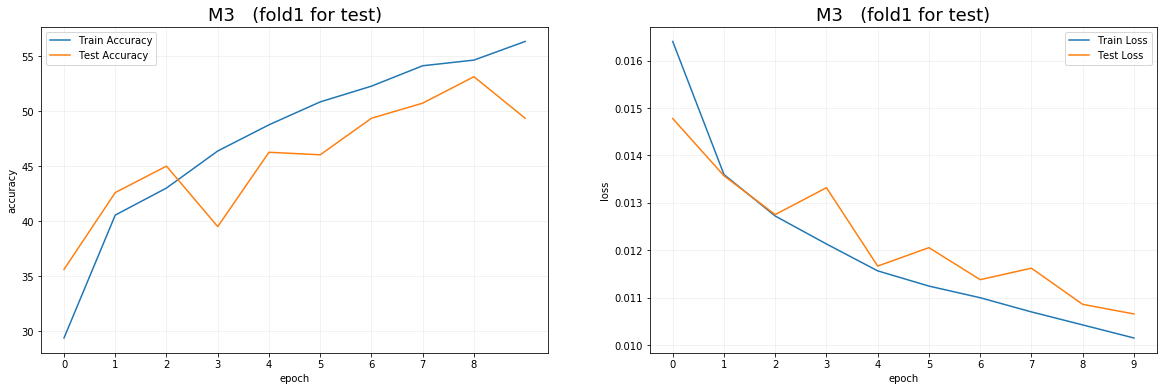

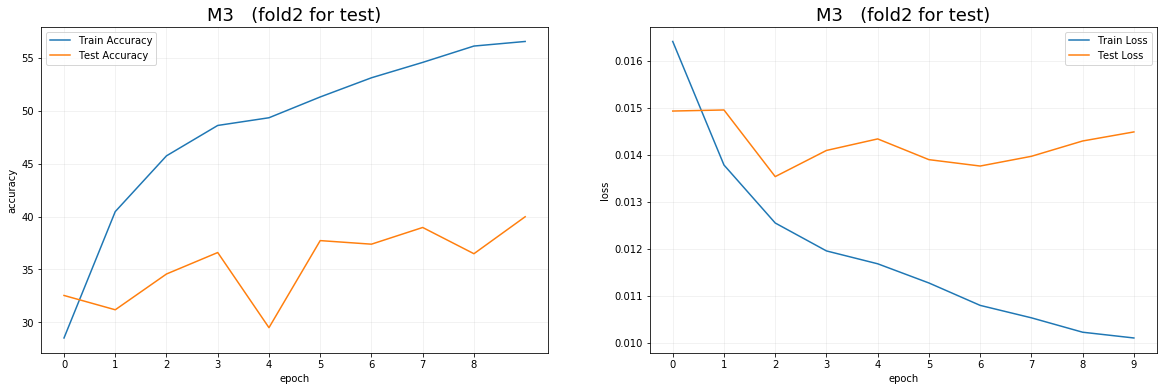

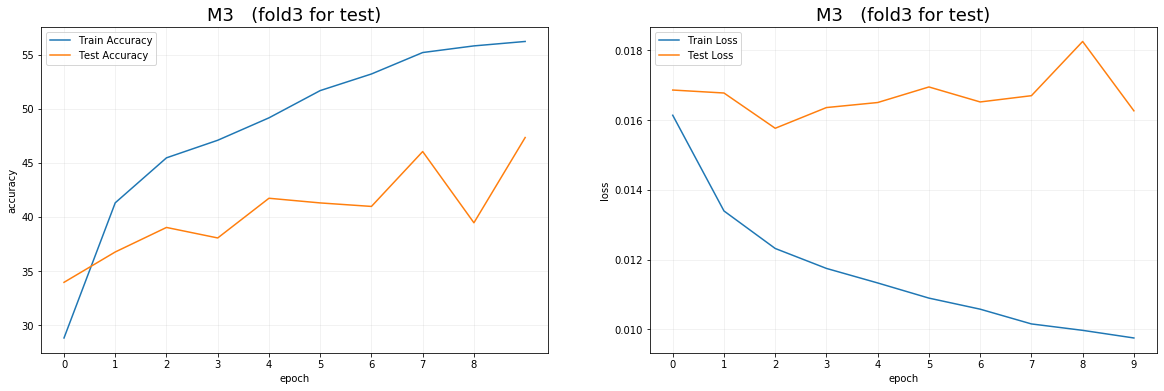

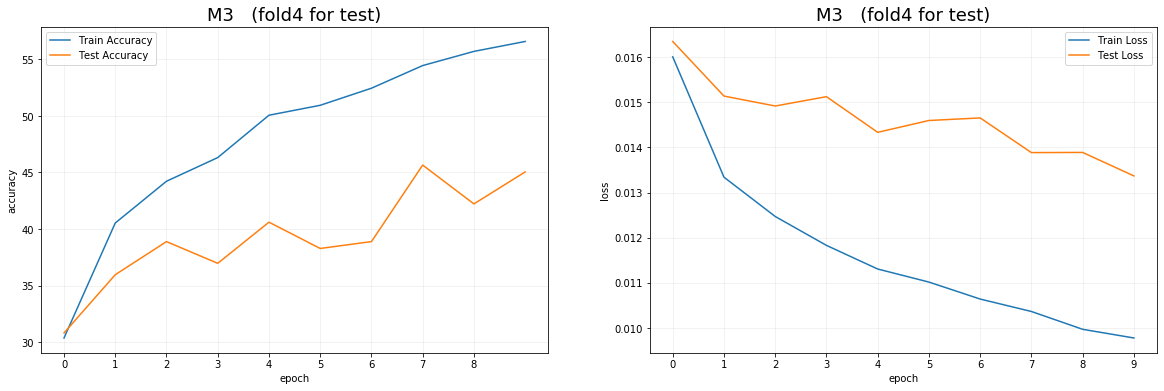

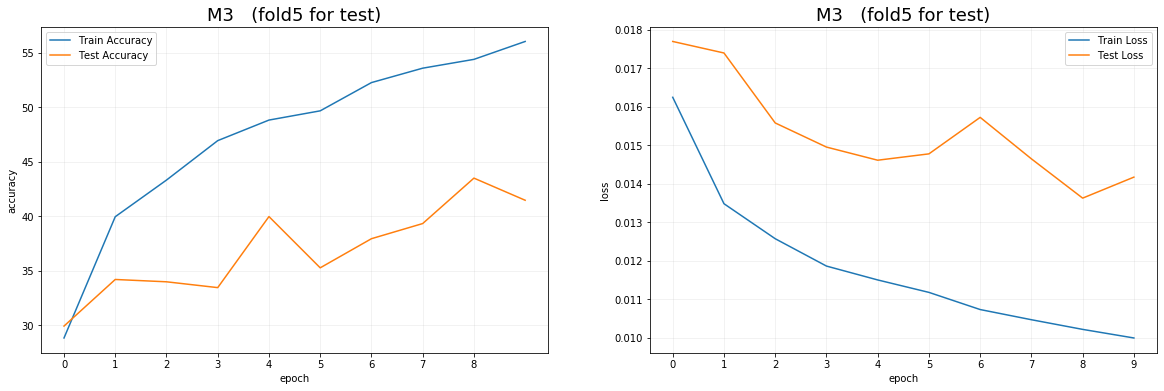

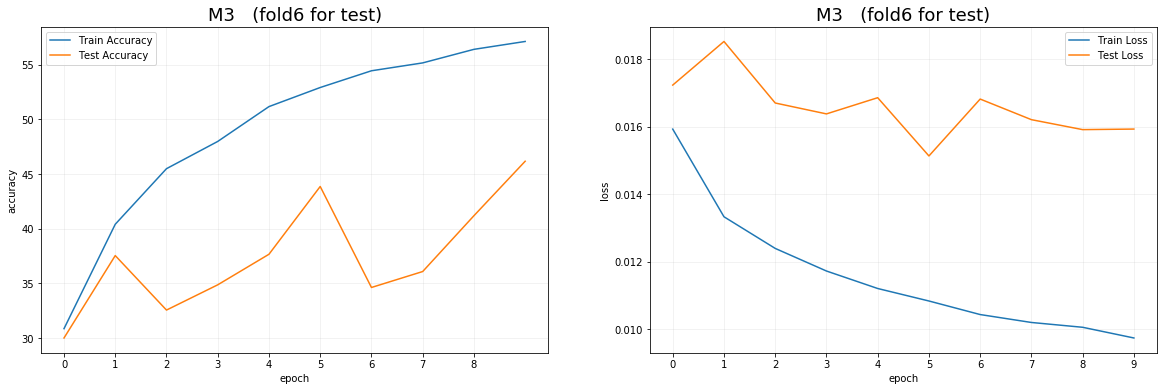

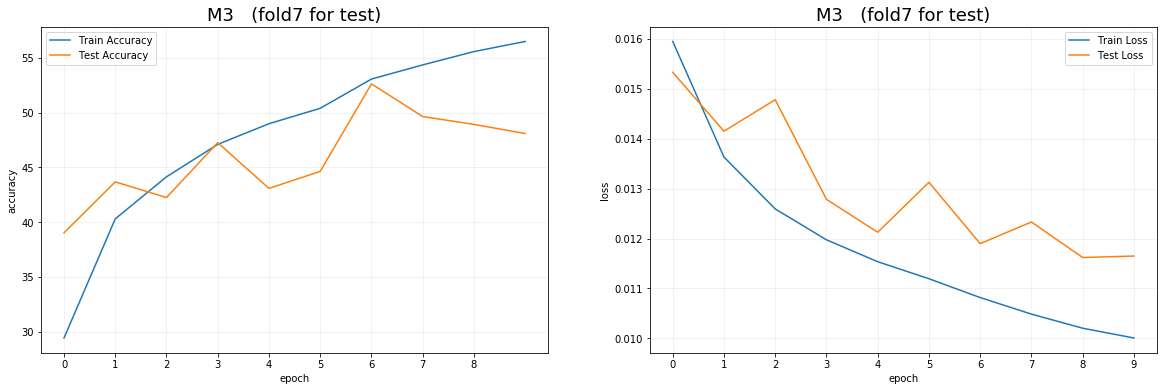

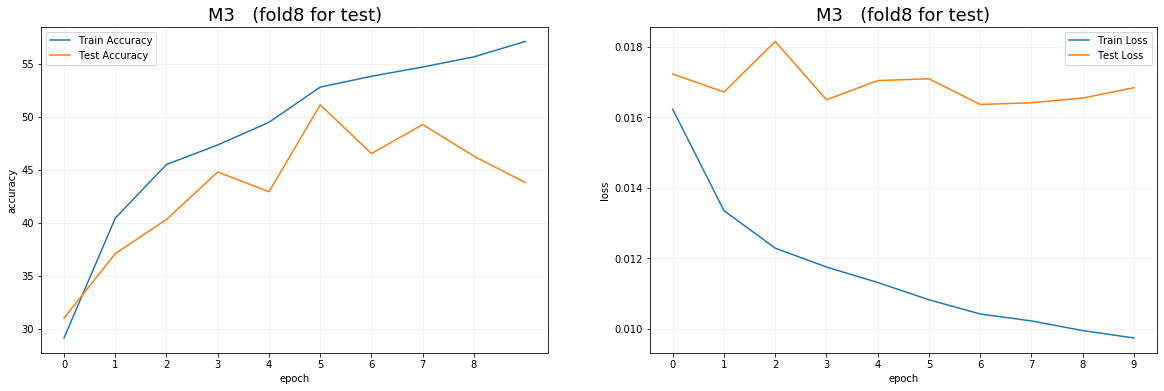

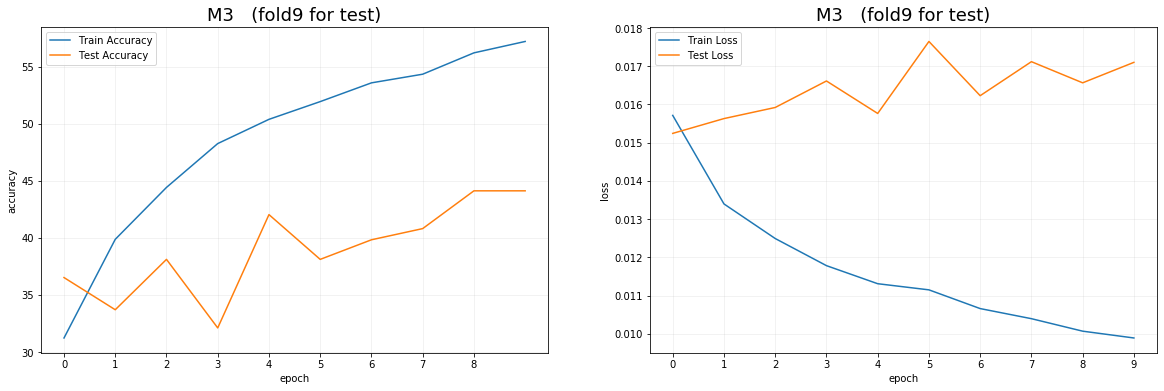

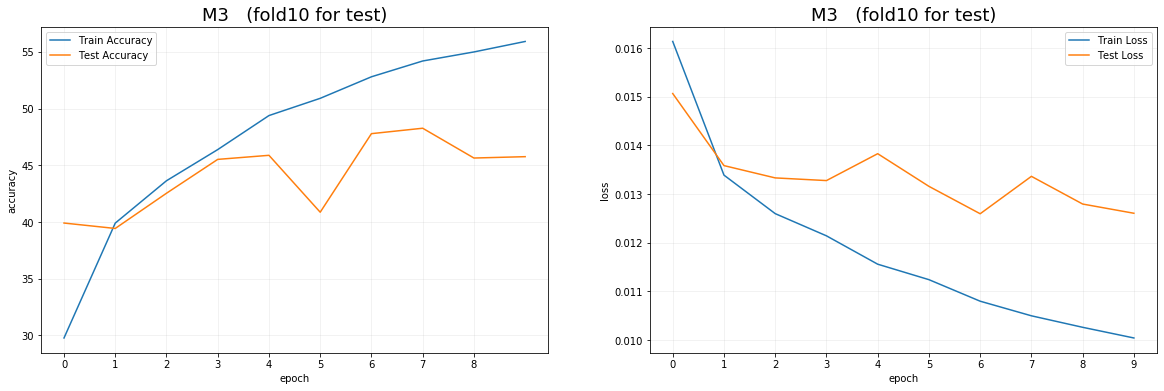

Cross validation for M3
Accuracy : 47.19%
Loss     : 0.0167

##########################################################################################



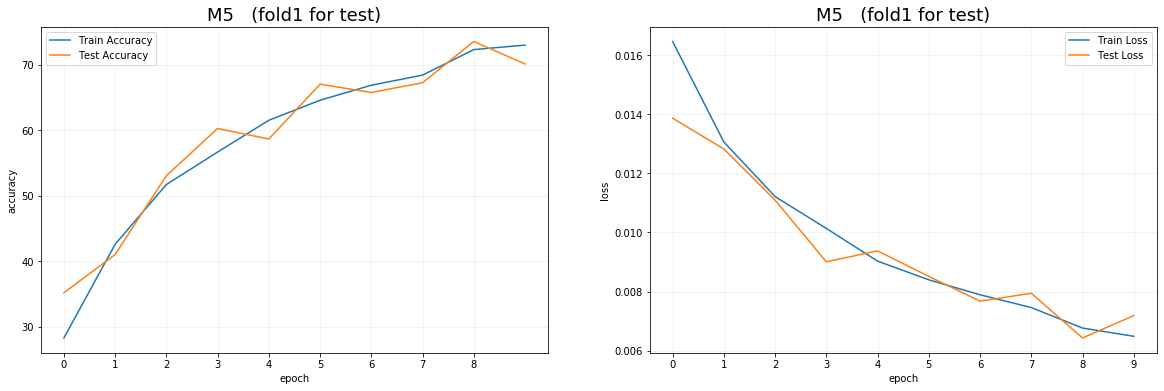

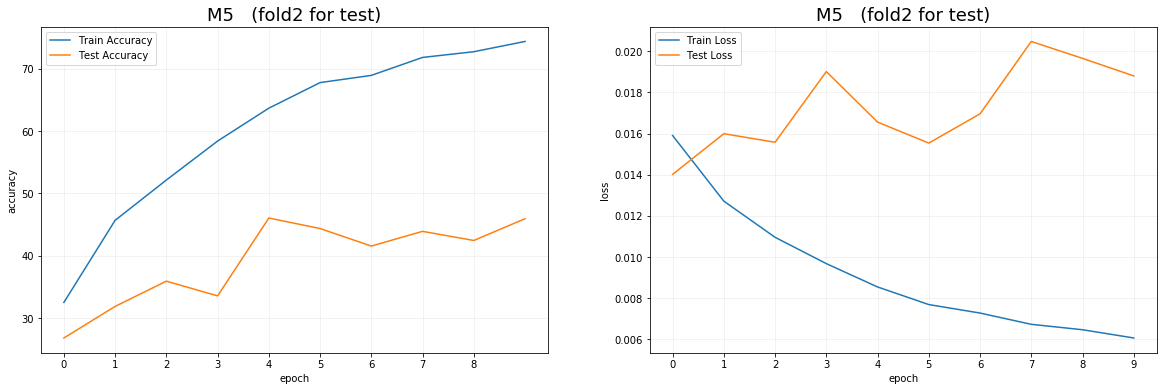

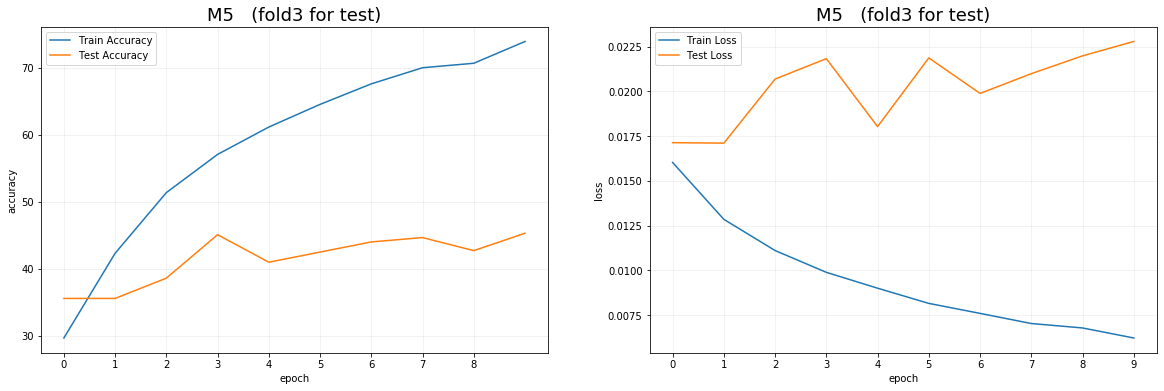

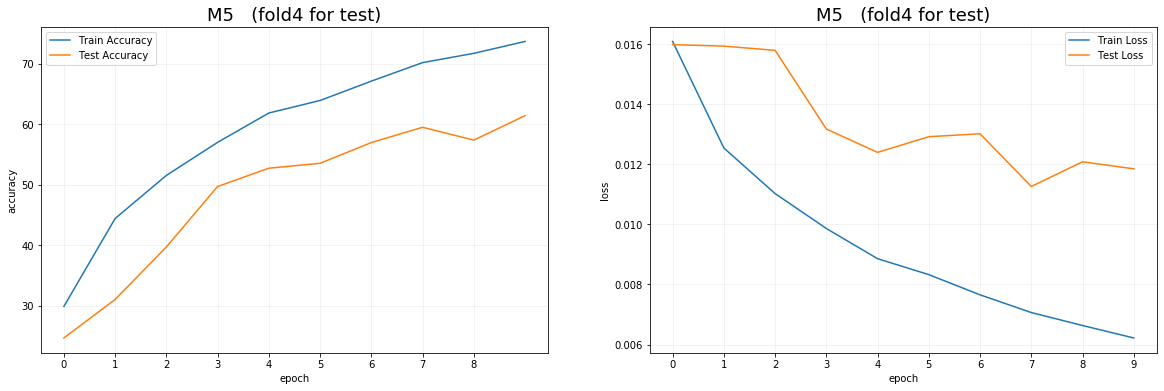

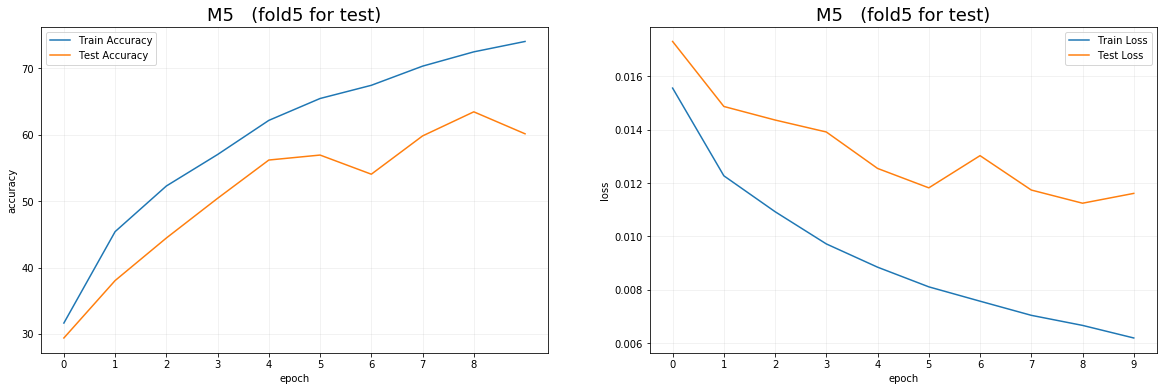

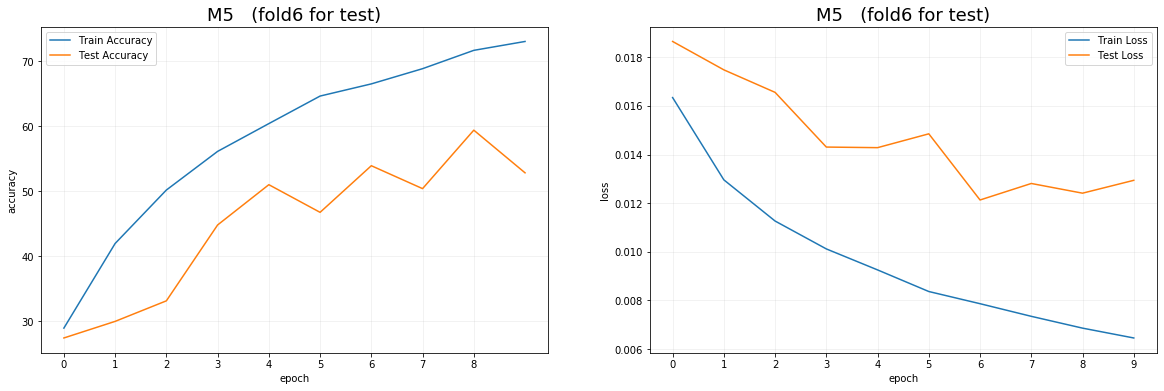

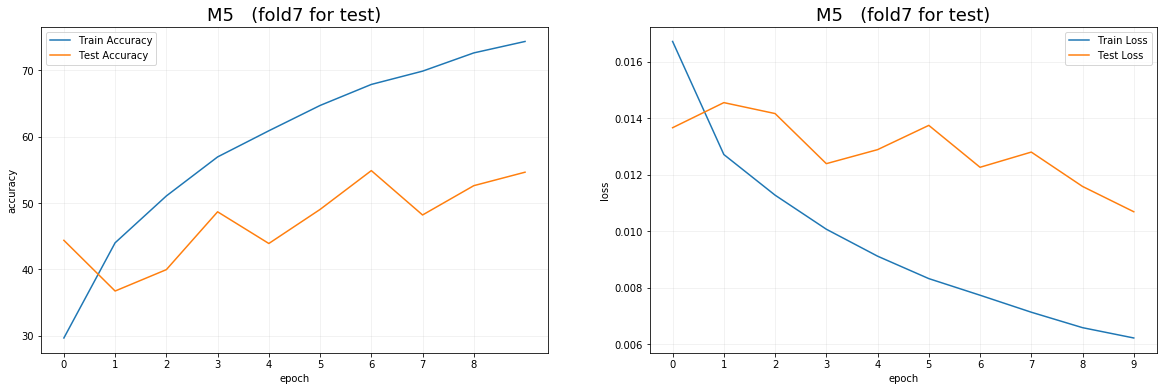

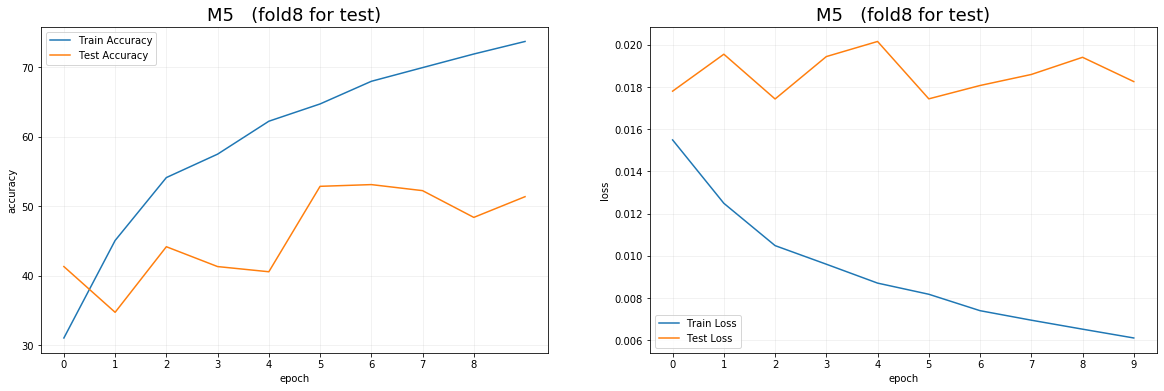

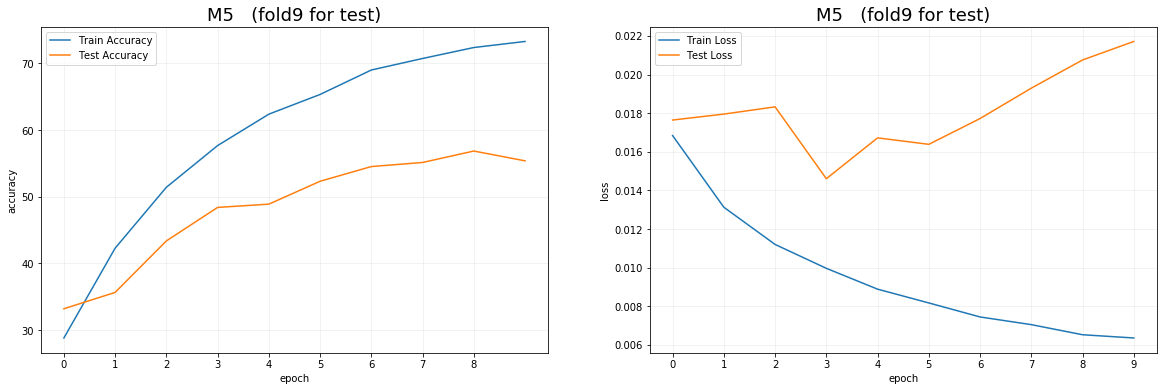

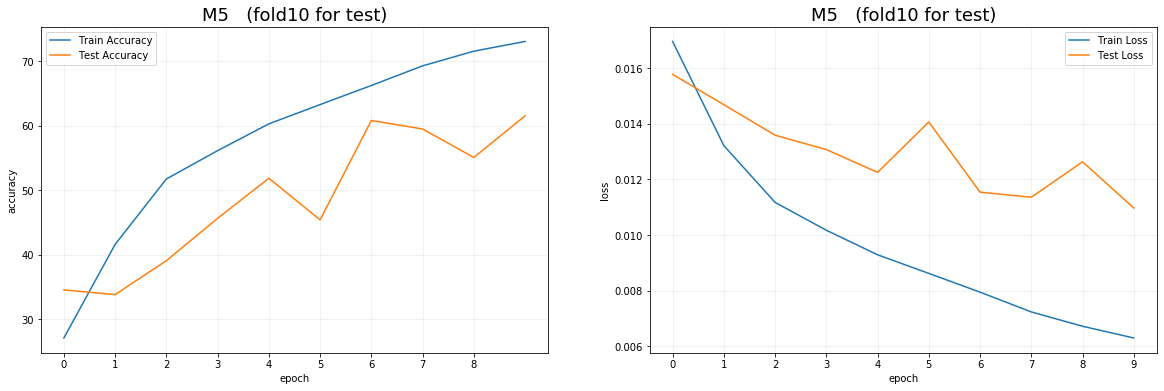

Cross validation for M5
Accuracy : 57.56%
Loss     : 0.0181

##########################################################################################



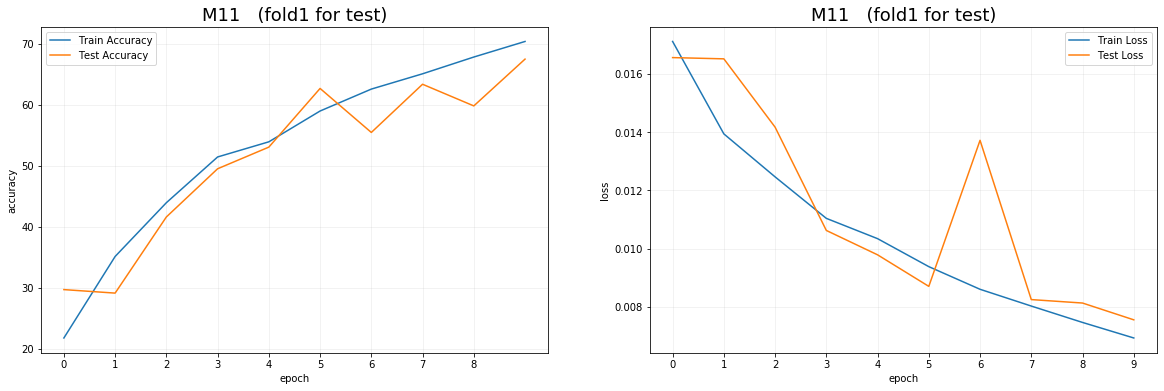

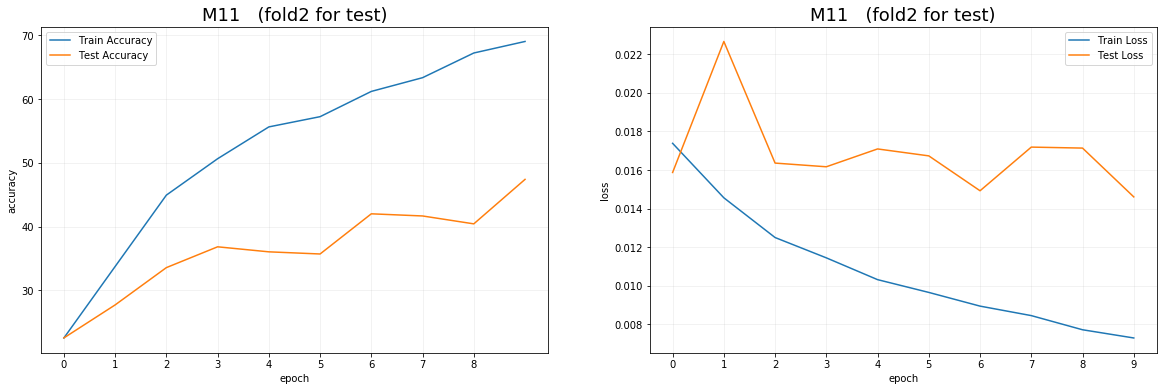

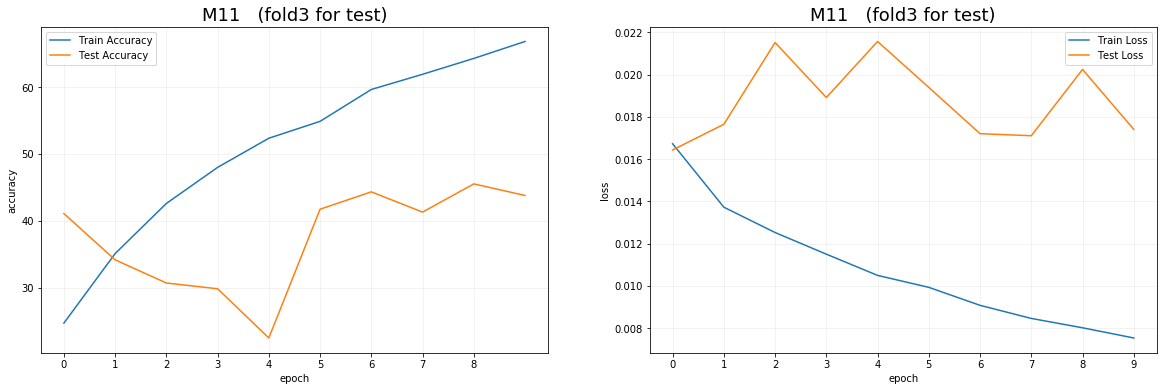

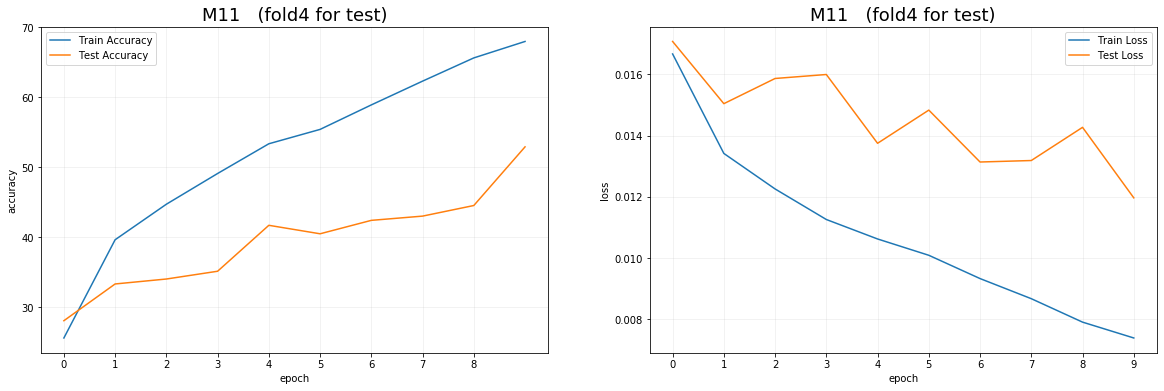

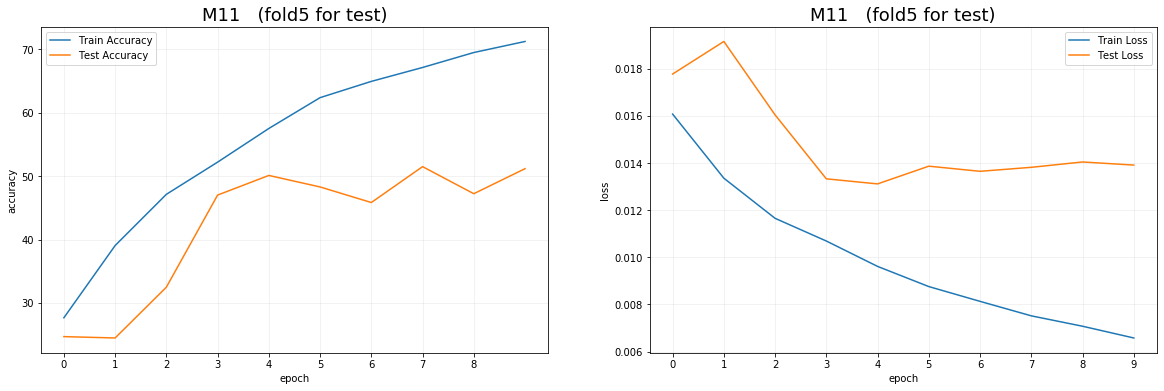

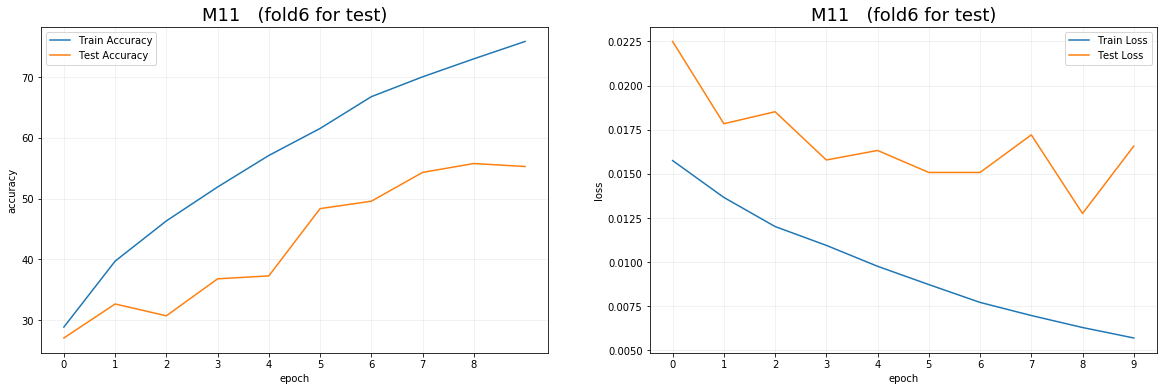

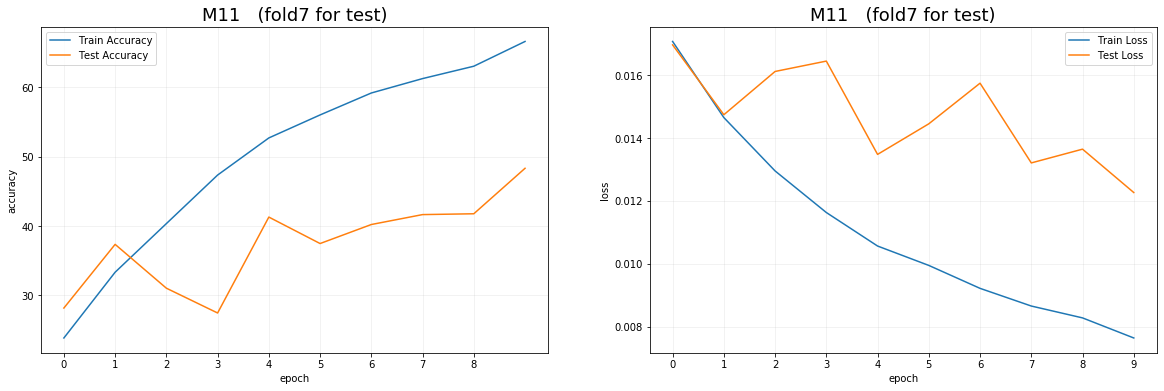

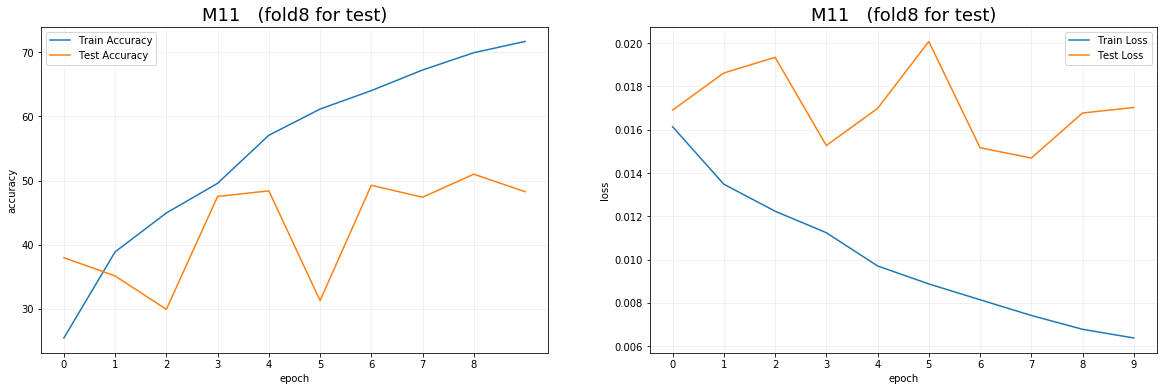

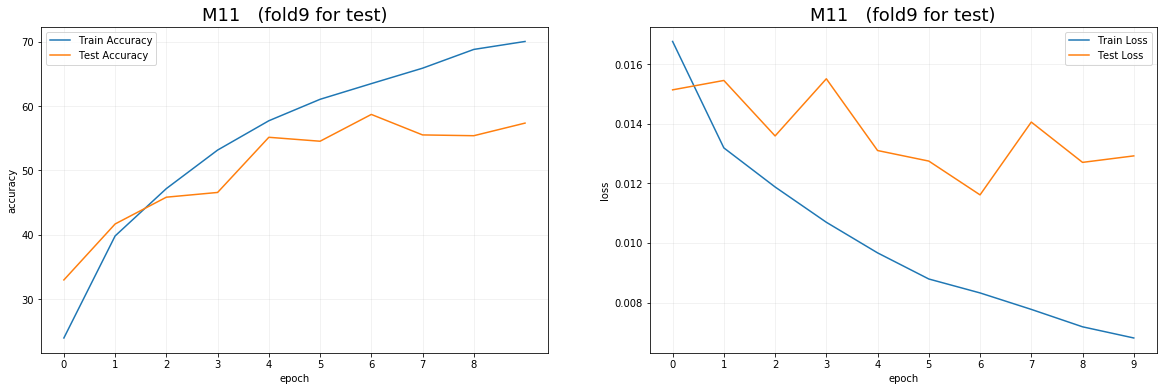

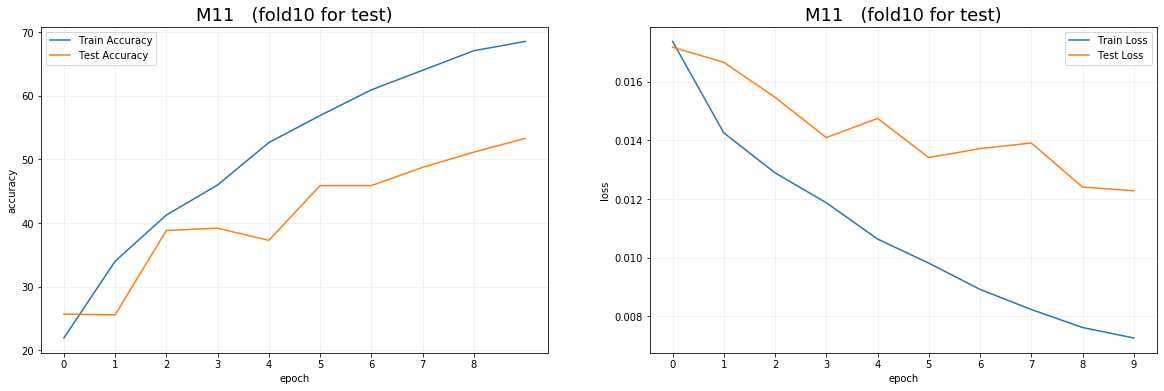

Cross validation for M11
Accuracy : 53.19%
Loss     : 0.0189

##########################################################################################



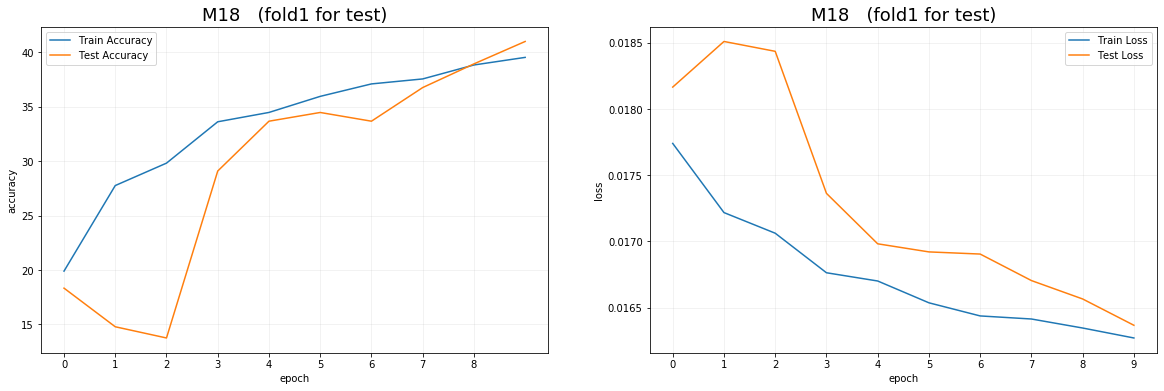

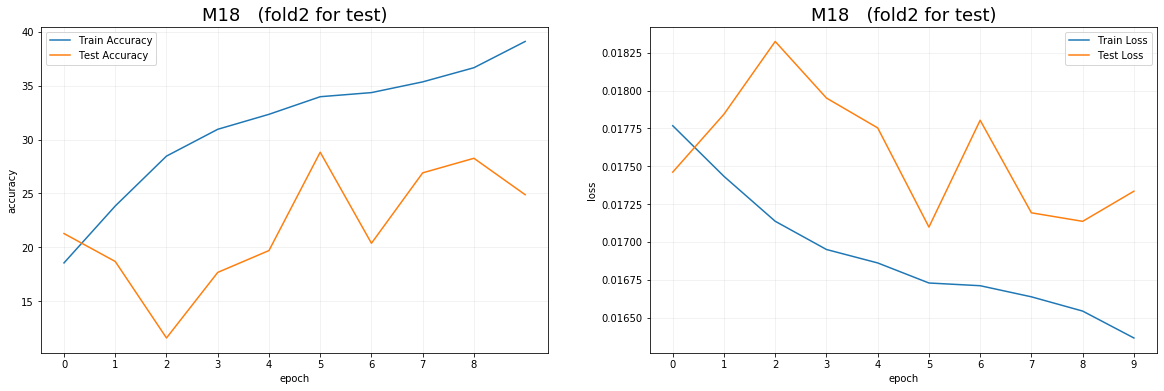

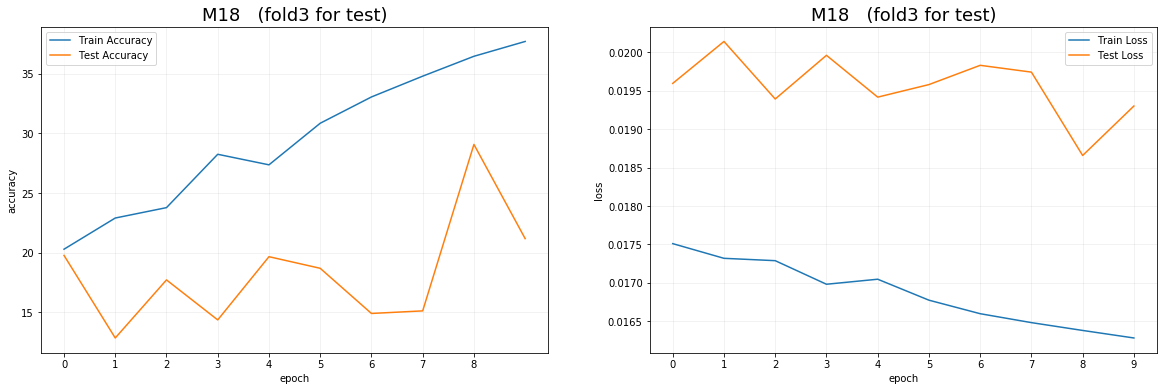

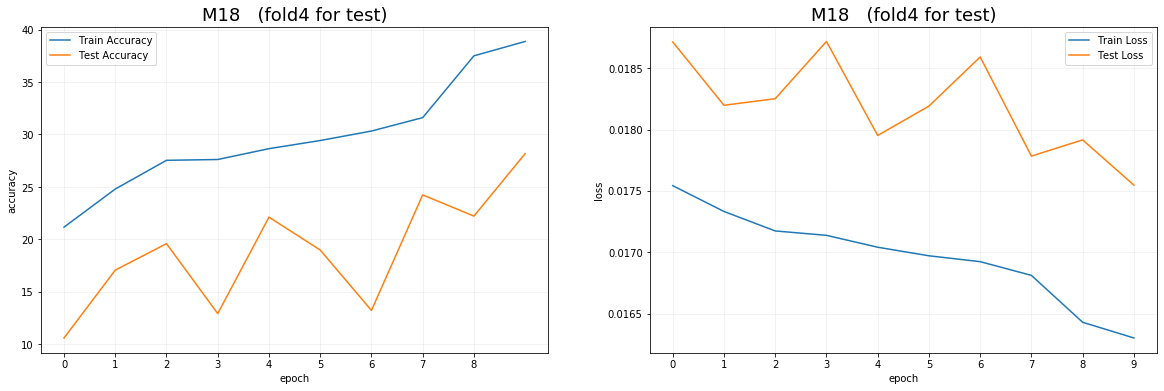

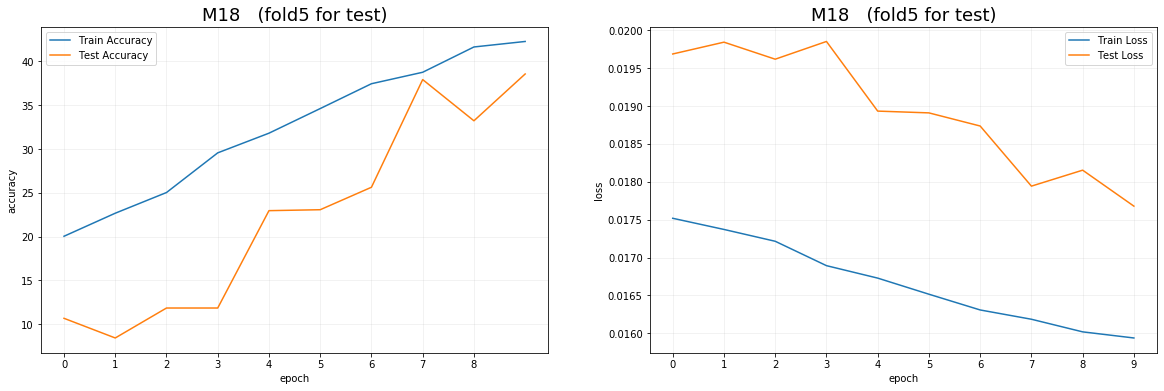

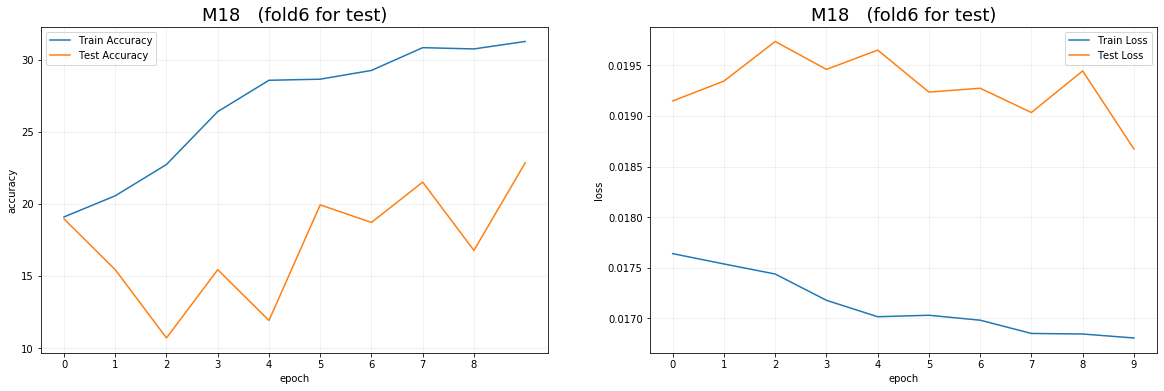

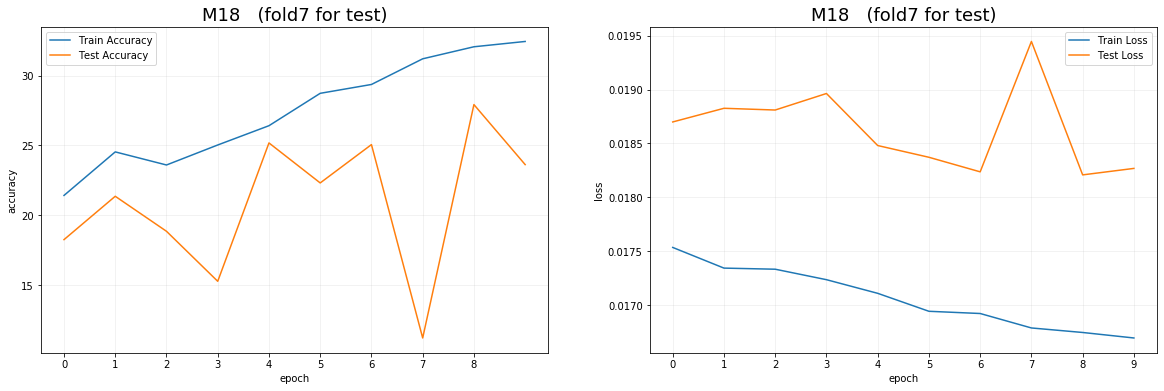

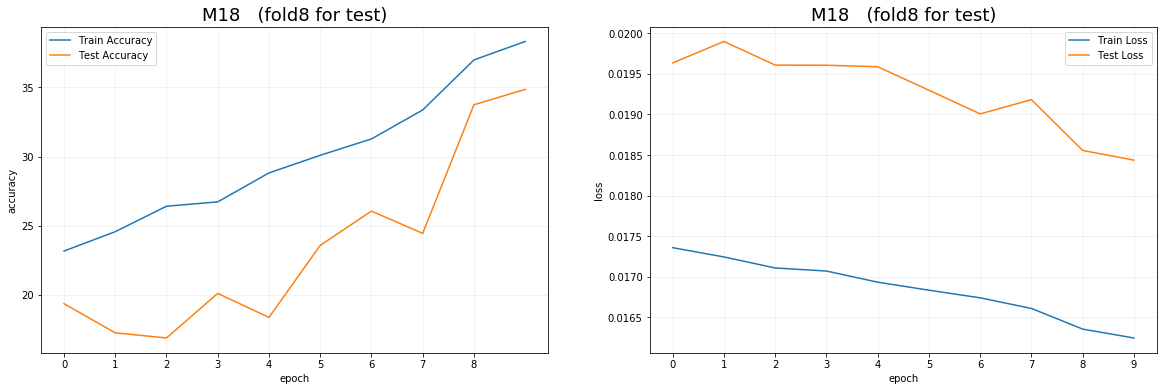

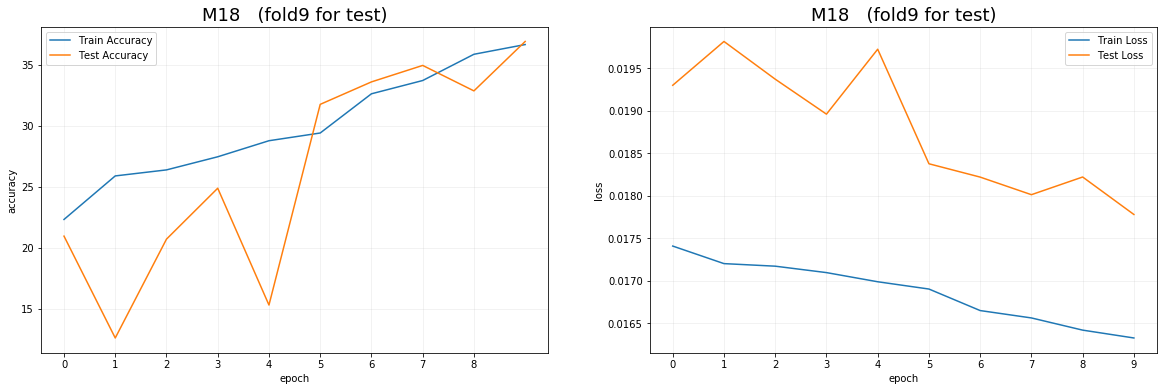

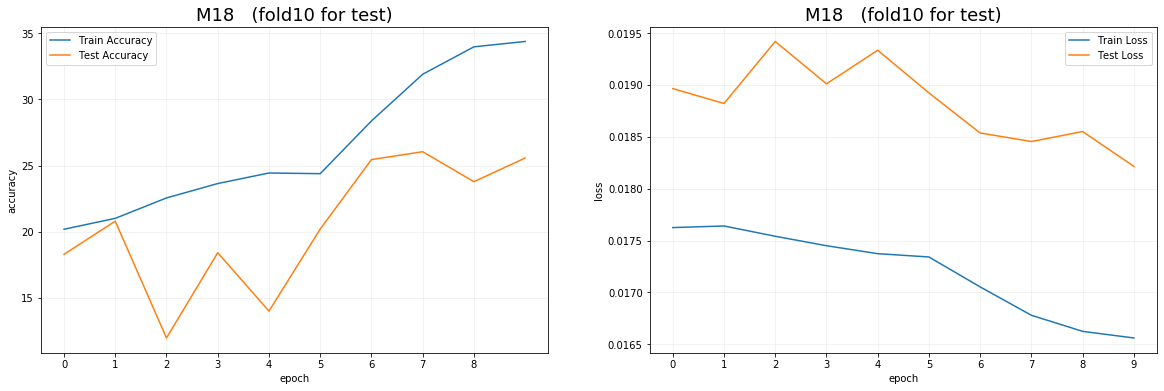

Cross validation for M18
Accuracy : 31.42%
Loss     : 0.0194

##########################################################################################



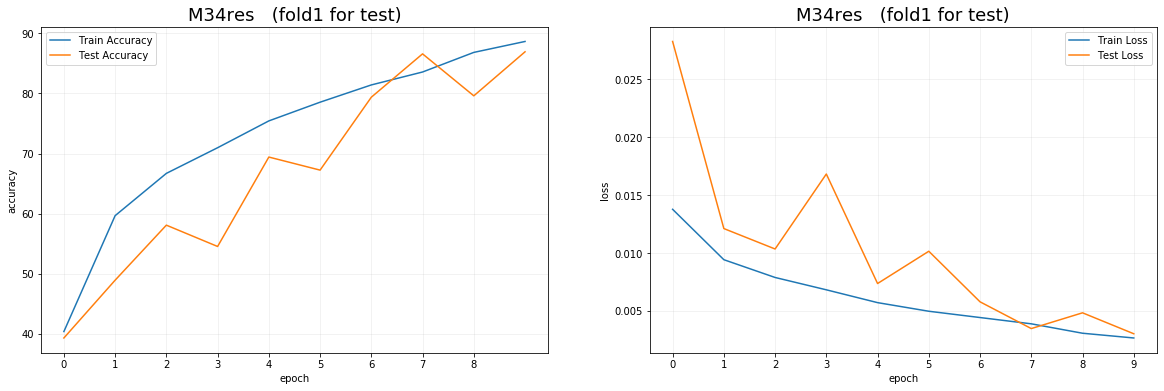

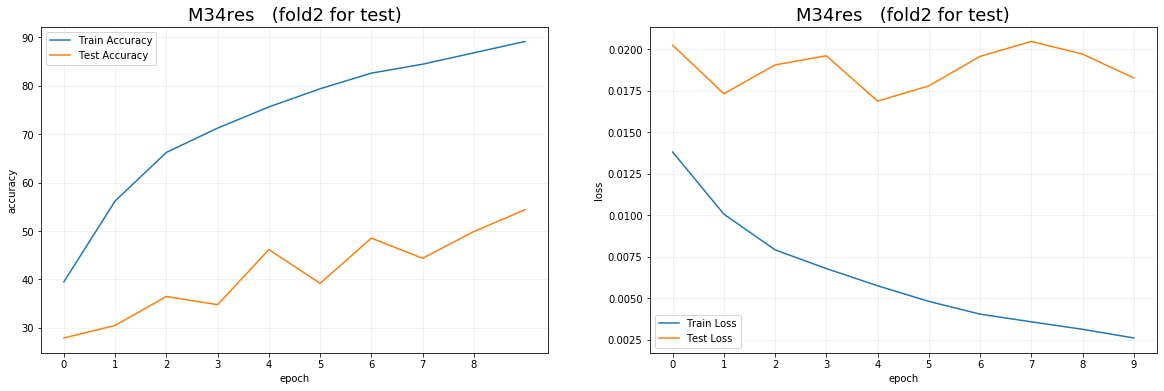

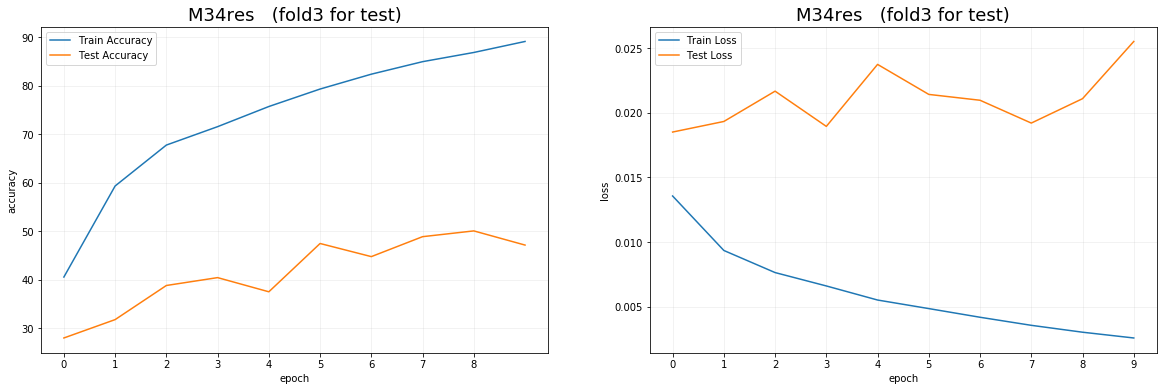

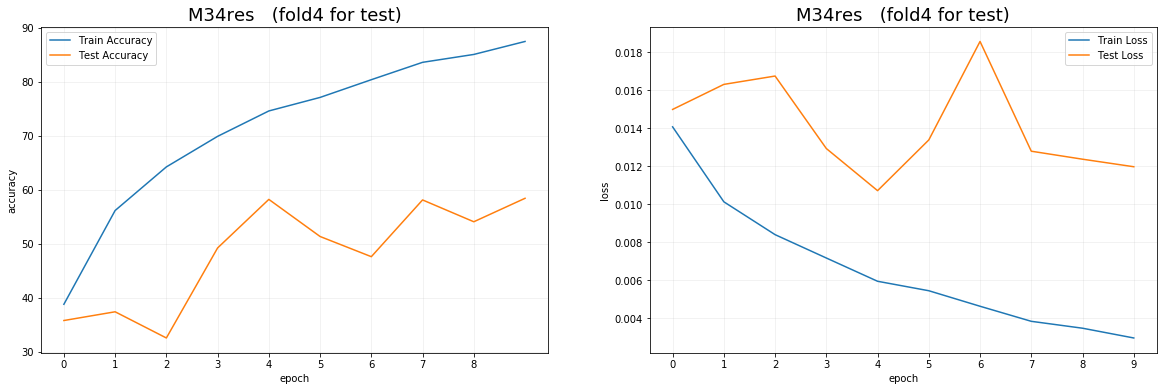

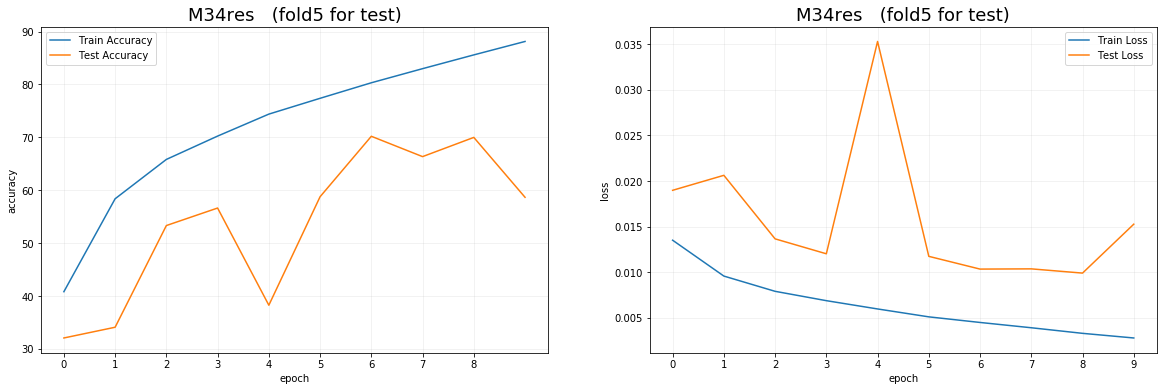

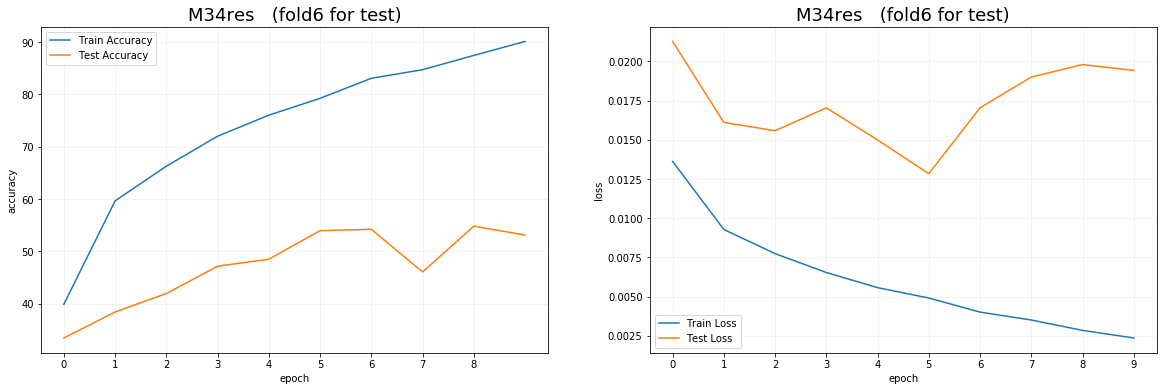

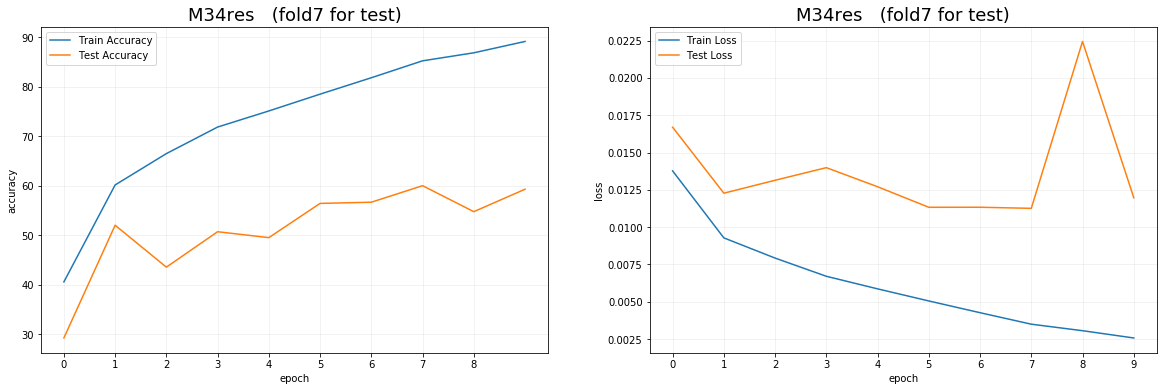

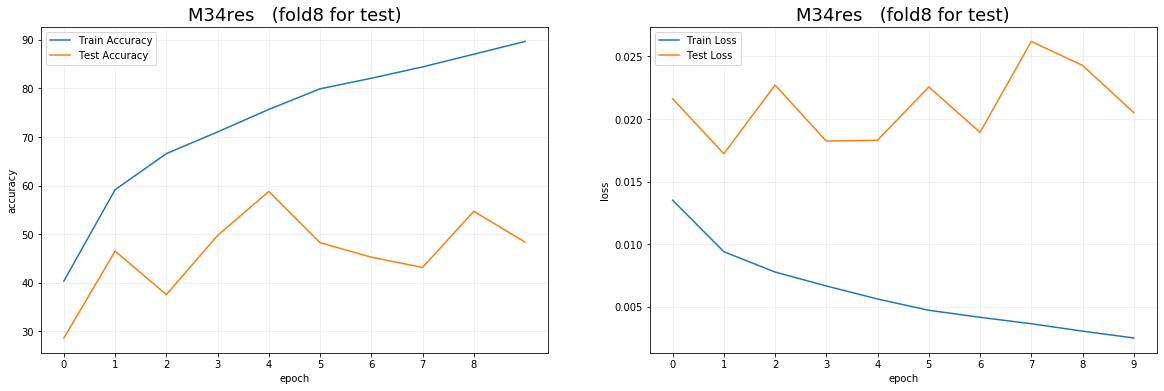

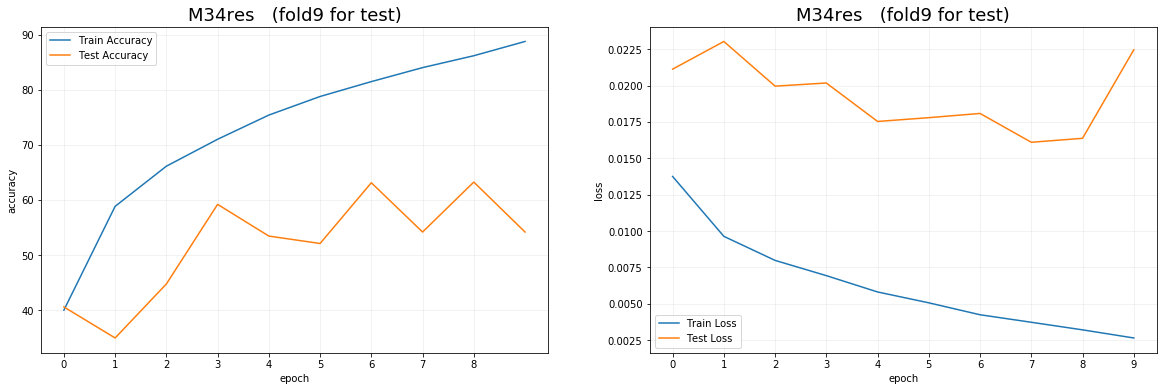

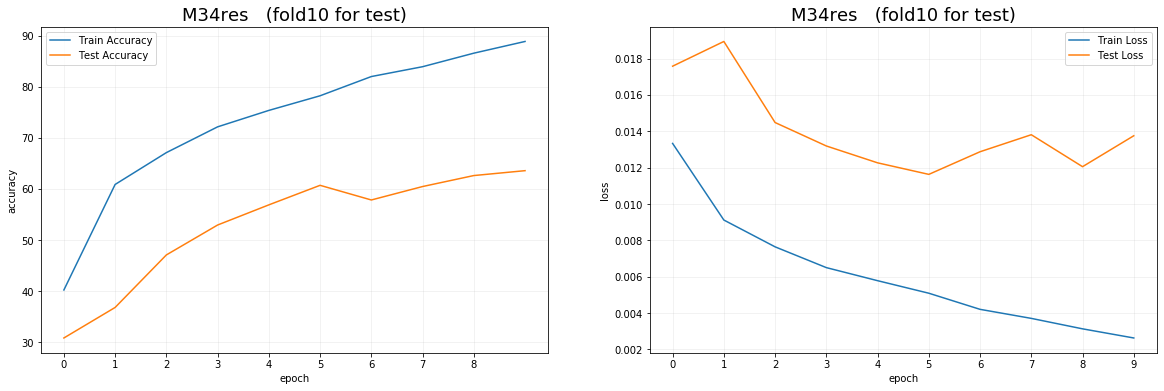

Cross validation for M34res
Accuracy : 62.04%
Loss     : 0.0240

##########################################################################################



In [ ]:
# 
import matplotlib.pyplot as plt

##### code for test
# log_path = '/content/drive/My Drive/audio_classification/logs'

#load the last store
# store = load_store(log_path)
# store = load_store(filename='/content/drive/My Drive/audio_classification/logs/10epoch-final-log.M34res-fold10_11-22h:54m.dict')
for model_name, folds in store_.items():

    cross_validated_acc  = 0
    cross_validated_loss = 0
    for fold_name, logs in folds.items():
        # create figure for subplot
        plt.figure(figsize=(20,6))

        plot_title = model_name+'   ('+fold_name + ' for test)'
        plt.subplot(121)
        plt.title(plot_title, fontsize=18)
        plt.plot(np.array(logs['train_acc'])*100, label="Train Accuracy")
        plt.plot(np.array(logs['test_acc'])*100,  label="Test Accuracy")
        plt.xticks(np.arange(0, 9, step=1))
        plt.rcParams['grid.alpha'] = .2
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.grid(True)
        plt.legend()

        plt.subplot(122)
        plt.title(plot_title, fontsize=18)
        plt.plot(logs['train_loss'], label="Train Loss")
        plt.plot(logs['test_loss'], label="Test Loss")
        plt.xticks(np.arange(0, 10, step=1))
        plt.rcParams['grid.alpha'] = .2
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.grid(True)
        plt.legend()

        plt.show()

        cross_validated_acc  += np.max(logs['test_acc'])
        cross_validated_loss += np.max(logs['test_loss'])

    print('Cross validation for', model_name)
    print('Accuracy : {:.2f}%'.format(cross_validated_acc/10*100))
    print('Loss     : {:.4f}'.format(cross_validated_loss/10))
    print('\n'+'#'*90+'\n')